In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from typing import List, Optional, Union
from typing import Tuple
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
def set_seed(seed=42):
    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

In [2]:
# Call this at the beginning of your script
set_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2048
EPOCHS = 500 # Set the total number of epochs you want to train for
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [4]:
df_train = pd.read_csv("./UNSWNB15/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("./UNSWNB15/UNSW_NB15_testing-set.csv")

In [5]:
encode_cols = ['proto', 'service', 'state']
#df_train = df_train.drop(columns=encode_cols)
#df_test  = df_test.drop(columns=encode_cols)

label_encoders = {}
for col in encode_cols:
    le = LabelEncoder()
    # Fit on combined train + test to ensure consistency
    combined_data = pd.concat([df_train[col], df_test[col]], axis=0)
    le.fit(combined_data)

    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

    label_encoders[col] = le  # Save encoder for later use

In [6]:
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,113,0,4,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,113,0,4,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,113,0,4,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,113,3,4,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,113,0,4,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [7]:
df_test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,119,0,5,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,119,0,5,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,119,0,5,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,119,0,5,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,119,0,5,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [8]:
X_train = df_train.drop(['label','attack_cat'], axis=1)
y_train = df_train['label']

X_test = df_test.drop(['label','attack_cat'], axis=1)
y_test = df_test['label']

X_train = X_train.loc[:, (X_train >= 0).all()]
X_train = np.log1p(X_train)

X_test = X_test.loc[:, (X_test >= 0).all()]
X_test = np.log1p(X_test)

# power = 1/2
# X_train = np.power(X_train, power)
# X_test = np.power(X_test, power)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("x_train shape:",X_train_scaled.shape,"| y_train shape:",y_train.shape,"| x_test shape:",X_test_scaled.shape,"| y_test shape:",y_test.shape)

x_train shape: (175341, 43) | y_train shape: (175341,) | x_test shape: (82332, 43) | y_test shape: (82332,)


In [9]:
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [10]:
class IndexedDataset(Dataset):
    def __init__(self, X_tensor, y_tensor):
        self.X = X_tensor
        self.y = y_tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx

train_dataset = IndexedDataset(x_train_tensor,y_train_tensor)
test_dataset = IndexedDataset(x_test_tensor,y_test_tensor)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

# Initialize per-sample weights (1.0 for all)
sample_weights = torch.ones(len(x_train_tensor), dtype=torch.float32)
sample_weights = sample_weights.to(device)

In [11]:
class ActivationNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.layer = nn.Linear(num_features, 8)
        self.drop = nn.Dropout(0.8)
        self.bn = nn.BatchNorm1d(8)
        
        self.y0_head = nn.Linear(8, 1)
        self.m_head  = nn.Linear(8, 1)
        self.x0_head = nn.Linear(8, 1)
        self.combine = nn.Linear(3, 3)

    def forward(self, x):
        h = self.layer(x)
        h = torch.tanh(h)
        h = self.bn(h)
        h = self.drop(h)
        
        y0 = self.y0_head(h)
        m  = self.m_head(h)
        x0 = self.x0_head(h)
        
        params = torch.cat([y0, m, x0], dim=-1)
        params = self.combine(params)
        
        y0, m, x0 = params[:,0:1], params[:,1:2], params[:,2:3]
        
        y = y0 + m * (x - x0)
        
        return [x, y], [x0, y0, m]

In [12]:
class KDD_Model(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        # Block 1
        self.layer1 = nn.Linear(input_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.activation1 = ActivationNet(512)
        self.drop1 = nn.Dropout(0.8)

        # Block 2
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.activation2 = ActivationNet(256)
        self.drop2 = nn.Dropout(0.8)

        # Block 3
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.activation3 = ActivationNet(128)
        self.drop3 = nn.Dropout(0.8)

        # Residual Block 4
        self.layer4 = nn.Linear(128, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.activation4 = ActivationNet(128)
        self.drop4 = nn.Dropout(0.8)

        # Down to latent
        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.activation5 = ActivationNet(64)

        # Bottleneck
        self.layer6 = nn.Linear(64, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.activation6 = ActivationNet(32)

        # Output
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        # Block 1
        out1, internal_out1 = self.activation1(self.bn1(self.layer1(x)))
        x = self.drop1(out1[1])

        # Block 2
        out2, internal_out2 = self.activation2(self.bn2(self.layer2(x)))
        x = self.drop2(out2[1])

        # Block 3
        out3, internal_out3 = self.activation3(self.bn3(self.layer3(x)))
        x = self.drop3(out3[1])

        # Residual Block 4
        res = x
        out = self.layer4(x)
        out = self.bn4(out)
        out4, internal_out4 = self.activation4(out)
        out = self.drop4(out4[1])
        x = out + res  # residual skip

        # Block 5
        out5, internal_out5 = self.activation5(self.bn5(self.layer5(x)))

        # Block 6
        out6, internal_out6 = self.activation6(self.bn6(self.layer6(out5[1])))

        # Output
        x = self.output_layer(out6[1])

        return x, [out1, out2, out3, out4, out5, out6], [internal_out1, internal_out2, internal_out3, internal_out4, internal_out5, internal_out6]

In [13]:
# --- File Paths ---
BEST_MODEL_PATH = "./UNSWNB15/results_mv_1d/best_model_f1.pth"
CHECKPOINT_PATH = "./UNSWNB15/results_mv_1d/training_checkpoint.pth"
LOGS_PATH = "./UNSWNB15/results_mv_1d/training_logs.csv"

In [14]:
input_features = X_train_scaled.shape[1]
        
model = KDD_Model(input_features)
model = model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none')

optimizer = optim.SGD(
    model.parameters(),
    lr=0.05,          # start higher than Adam
    momentum=0.9,
    nesterov=True,
    weight_decay=5e-4
)

In [15]:
# Checkpoint Loading (Resume Logic)

THRESH = 0.5  # <- your decision threshold
start_epoch = 0
best_f1_score = 0.0
history = []

# Check if a checkpoint file exists
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found! Resuming training from {CHECKPOINT_PATH}")
    # Load the checkpoint
    checkpoint = torch.load(CHECKPOINT_PATH, weights_only=False)
    
    # Restore the state
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    
    # Find the best F1 score from the loaded history to continue tracking
    if history:
        # This gets the 'test_f1' value from each dictionary in the history list
        best_f1_score = max([epoch_data.get('test_f1', 0) for epoch_data in history])
    
    print(f"Resuming from epoch {start_epoch}. Best Test F1 so far: {best_f1_score:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")

Checkpoint found! Resuming training from ./UNSWNB15/results_mv_1d/training_checkpoint.pth
Resuming from epoch 500. Best Test F1 so far: 0.7726


In [34]:
def update_sample_weights(
    model: nn.Module,
    data_loader: DataLoader,
    current_weights: torch.Tensor,
    device: torch.device,
    threshold: float = 0.5,
    increase_factor: float = 1.2,
    decrease_factor: float = 0.9,
    min_weight: float = 0.1,
    max_weight: float = 5.0
) -> torch.Tensor:

    model.eval()  # Set model to evaluation mode for consistent predictions
    
    all_preds = []
    all_labels = []
    all_indices = []
    
    with torch.no_grad():
        # Loop through the entire dataset to get predictions
        for inputs, labels, indices in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs, _, _ = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).float()
            
            all_preds.append(preds.view(-1))
            all_labels.append(labels.view(-1))
            all_indices.append(indices.to(device)) # Keep indices on the same device
            
    # Concatenate all batch results into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_indices = torch.cat(all_indices)

    # Identify incorrect and correct predictions using a boolean mask
    incorrect_mask = (all_preds != all_labels)
    correct_mask = ~incorrect_mask

    # Use the boolean masks to get the global indices of the samples
    incorrect_indices = all_indices[incorrect_mask]
    correct_indices = all_indices[correct_mask]

    # Update weights for the identified samples
    # Note: We update the original 'current_weights' tensor
    current_weights[incorrect_indices] *= increase_factor
    current_weights[correct_indices] *= decrease_factor
    
    # Clamp the weights to a reasonable range and return
    return current_weights.clamp(min=min_weight, max=max_weight)

In [35]:
# Evaluation Function

@torch.no_grad()
def evaluate_model_threshold(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_count = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc=f"Testing", leave=True)

    for inputs, labels, _ in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).view(-1).long()
        outputs, _, _ = model(inputs)

        # logits -> probs
        probs = torch.sigmoid(outputs.view(-1))
        preds = (probs >= THRESH).long()

        # per-sample loss (no weights on test unless you have a test weight vector)
        losses = loss_fn(outputs.view(-1), labels.float()).mean()

        batch_size = labels.size(0)
        total_loss += losses.item() * batch_size
        total_count += batch_size

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(loss=total_loss / total_count)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Accuracy via thresholded preds
    acc = (all_preds == all_labels).mean()

    # Macro P/R/F1 (over classes 0 and 1)
    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    avg_loss = total_loss / total_count
    return avg_loss, acc, p, r, f1

In [36]:
# ---------------- Main Training Loop ----------------
for epoch in range(start_epoch, EPOCHS):
    model.train()

    # running stats for TRAIN (weighted loss averaged by total weight)
    total_weighted_loss = 0.0
    total_count = 0.0

    train_all_preds = []
    train_all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

    for inputs, labels, indices in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1).long()
        indices = indices.to(device)

        # ---- Forward ----
        outputs, _, _ = model(inputs)  # shape [B, 1] or [B]
        logits = outputs.view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs >= THRESH).long()

        # per-sample loss (assumes BCEWithLogitsLoss(reduction='none'))
        losses = loss_fn(logits, labels.float()).view(-1)

        # weights
        batch_weights = sample_weights[indices]  # shape [B]
        weighted_loss = (losses * batch_weights).mean()

        # ---- Backward ----
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        # ---- Accumulate epoch stats ----
        batch_size = labels.size(0)
        total_weighted_loss += weighted_loss.item() * batch_size
        total_count += batch_size

        train_all_preds.append(preds.detach().cpu())
        train_all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(weighted_loss=total_weighted_loss / total_count)
    
    # Update weights: increase for misclassified
    sample_weights = update_sample_weights(
        model=model,
        data_loader=train_loader,
        current_weights=sample_weights,
        device=device,
        threshold=THRESH
    )

    # ---- TRAIN epoch metrics (threshold-based) ----
    train_all_preds = torch.cat(train_all_preds).numpy()
    train_all_labels = torch.cat(train_all_labels).numpy()

    train_weighted_loss = total_weighted_loss / total_count
    train_acc = (train_all_preds == train_all_labels).mean()
    train_p, train_r, train_f1, _ = precision_recall_fscore_support(
        train_all_labels, train_all_preds, average='macro', zero_division=0
    )

    # ---- TEST evaluation (single pass, threshold-based) ----
    test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        model, test_loader, loss_fn, device
    )
    
    #scheduler.step(test_f1)

    # ---- Logging ----
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_weighted_loss:.4f}, Acc(th={THRESH}): {train_acc:.4f}, "
        f"P: {train_p:.4f}, R: {train_r:.4f}, F1: {train_f1:.4f} | "
        f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
        f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
    )

    epoch_data = {
        'epoch': epoch + 1,
        'train_loss': train_weighted_loss,
        'train_accuracy_threshold': train_acc,
        'train_precision': train_p,
        'train_recall': train_r,
        'train_f1': train_f1,
        'test_loss': test_loss,
        'test_accuracy_threshold': test_acc,
        'test_precision': test_p,
        'test_recall': test_r,
        'test_f1': test_f1,
        'threshold': THRESH,
    }
    history.append(epoch_data)
    pd.DataFrame(history).to_csv(LOGS_PATH, index=False)

    # ---- Save the Best Model by Test F1 ----
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🎉 New best model saved with Test F1 Score: {best_f1_score:.4f}")

    # ---- Checkpoint every epoch ----
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, CHECKPOINT_PATH)

print("="*60)
print("Training finished!")
print(f"Best model saved to: {BEST_MODEL_PATH} (Test F1: {best_f1_score:.4f})")
print(f"Full training logs saved to: {LOGS_PATH}")
print(f"Final checkpoint for resumption saved to: {CHECKPOINT_PATH}")

Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.66it/s, loss=0.718]


Epoch 1/500 | Train Loss: 0.6389, Acc(th=0.5): 0.6603, P: 0.4966, R: 0.4992, F1: 0.4411 | Test Loss: 0.7185, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551
🎉 New best model saved with Test F1 Score: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.59it/s, loss=0.696]


Epoch 2/500 | Train Loss: 0.6645, Acc(th=0.5): 0.6804, P: 0.5221, R: 0.5001, F1: 0.4058 | Test Loss: 0.6964, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.98it/s, loss=0.688]


Epoch 3/500 | Train Loss: 0.6972, Acc(th=0.5): 0.6787, P: 0.4903, R: 0.4998, F1: 0.4087 | Test Loss: 0.6881, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.27it/s, loss=0.632]


Epoch 4/500 | Train Loss: 0.7197, Acc(th=0.5): 0.3888, P: 0.5516, R: 0.5265, F1: 0.3657 | Test Loss: 0.6318, Acc(th=0.5): 0.7162, P: 0.7458, R: 0.7317, F1: 0.7144
🎉 New best model saved with Test F1 Score: 0.7144


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.02it/s, loss=0.98]


Epoch 5/500 | Train Loss: 0.5736, Acc(th=0.5): 0.7185, P: 0.6976, R: 0.7230, F1: 0.7000 | Test Loss: 0.9802, Acc(th=0.5): 0.5215, P: 0.5343, R: 0.5330, F1: 0.5198


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.07it/s, loss=1.4]


Epoch 6/500 | Train Loss: 0.2352, Acc(th=0.5): 0.9272, P: 0.9130, R: 0.9219, F1: 0.9172 | Test Loss: 1.4005, Acc(th=0.5): 0.5437, P: 0.5706, R: 0.5623, F1: 0.5363


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.86it/s, loss=1.45]


Epoch 7/500 | Train Loss: 0.2047, Acc(th=0.5): 0.9346, P: 0.9210, R: 0.9311, F1: 0.9257 | Test Loss: 1.4451, Acc(th=0.5): 0.5456, P: 0.5708, R: 0.5633, F1: 0.5391


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.55it/s, loss=1.39]


Epoch 8/500 | Train Loss: 0.2045, Acc(th=0.5): 0.9355, P: 0.9217, R: 0.9326, F1: 0.9268 | Test Loss: 1.3900, Acc(th=0.5): 0.5814, P: 0.6062, R: 0.5976, F1: 0.5772


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.60it/s, loss=1.27]


Epoch 9/500 | Train Loss: 0.2117, Acc(th=0.5): 0.9342, P: 0.9198, R: 0.9318, F1: 0.9254 | Test Loss: 1.2699, Acc(th=0.5): 0.6097, P: 0.6330, R: 0.6246, F1: 0.6070


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.15it/s, loss=1.3]


Epoch 10/500 | Train Loss: 0.2232, Acc(th=0.5): 0.9318, P: 0.9167, R: 0.9300, F1: 0.9228 | Test Loss: 1.3030, Acc(th=0.5): 0.5972, P: 0.6371, R: 0.6179, F1: 0.5888


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.04it/s, loss=1.2]


Epoch 11/500 | Train Loss: 0.2341, Acc(th=0.5): 0.9315, P: 0.9176, R: 0.9272, F1: 0.9221 | Test Loss: 1.2012, Acc(th=0.5): 0.5998, P: 0.6143, R: 0.6110, F1: 0.5989


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.03it/s, loss=1.05]


Epoch 12/500 | Train Loss: 0.2402, Acc(th=0.5): 0.9318, P: 0.9193, R: 0.9250, F1: 0.9221 | Test Loss: 1.0542, Acc(th=0.5): 0.6197, P: 0.6229, R: 0.6238, F1: 0.6196


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 38.35it/s, loss=1.03]


Epoch 13/500 | Train Loss: 0.2410, Acc(th=0.5): 0.9285, P: 0.9157, R: 0.9213, F1: 0.9184 | Test Loss: 1.0315, Acc(th=0.5): 0.6335, P: 0.6498, R: 0.6452, F1: 0.6325


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.63it/s, loss=0.994]


Epoch 14/500 | Train Loss: 0.2431, Acc(th=0.5): 0.9271, P: 0.9168, R: 0.9151, F1: 0.9159 | Test Loss: 0.9941, Acc(th=0.5): 0.6218, P: 0.6232, R: 0.6244, F1: 0.6213


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.41it/s, loss=0.883]


Epoch 15/500 | Train Loss: 0.2391, Acc(th=0.5): 0.9207, P: 0.9078, R: 0.9104, F1: 0.9091 | Test Loss: 0.8829, Acc(th=0.5): 0.6327, P: 0.6326, R: 0.6339, F1: 0.6317


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.05it/s, loss=0.874]


Epoch 16/500 | Train Loss: 0.2340, Acc(th=0.5): 0.9099, P: 0.8921, R: 0.9057, F1: 0.8982 | Test Loss: 0.8745, Acc(th=0.5): 0.6414, P: 0.6378, R: 0.6380, F1: 0.6379


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.68it/s, loss=0.835]


Epoch 17/500 | Train Loss: 0.2275, Acc(th=0.5): 0.8888, P: 0.8666, R: 0.8964, F1: 0.8776 | Test Loss: 0.8352, Acc(th=0.5): 0.6891, P: 0.7360, R: 0.7090, F1: 0.6842


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.77it/s, loss=0.838]


Epoch 18/500 | Train Loss: 0.2244, Acc(th=0.5): 0.8986, P: 0.8791, R: 0.8942, F1: 0.8858 | Test Loss: 0.8383, Acc(th=0.5): 0.6356, P: 0.6323, R: 0.6327, F1: 0.6324


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.95it/s, loss=0.815]


Epoch 19/500 | Train Loss: 0.2205, Acc(th=0.5): 0.8670, P: 0.8446, R: 0.8805, F1: 0.8556 | Test Loss: 0.8148, Acc(th=0.5): 0.6723, P: 0.7568, R: 0.6988, F1: 0.6599


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.79it/s, loss=0.773]


Epoch 20/500 | Train Loss: 0.2199, Acc(th=0.5): 0.8976, P: 0.8792, R: 0.8888, F1: 0.8837 | Test Loss: 0.7730, Acc(th=0.5): 0.6449, P: 0.6411, R: 0.6409, F1: 0.6410


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.09it/s, loss=0.773]


Epoch 21/500 | Train Loss: 0.2203, Acc(th=0.5): 0.8557, P: 0.8338, R: 0.8711, F1: 0.8441 | Test Loss: 0.7733, Acc(th=0.5): 0.6991, P: 0.7655, R: 0.7223, F1: 0.6916


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.29it/s, loss=0.821]


Epoch 22/500 | Train Loss: 0.2197, Acc(th=0.5): 0.8853, P: 0.8643, R: 0.8789, F1: 0.8708 | Test Loss: 0.8209, Acc(th=0.5): 0.6552, P: 0.6541, R: 0.6556, F1: 0.6539


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.63it/s, loss=0.74]


Epoch 23/500 | Train Loss: 0.2180, Acc(th=0.5): 0.8755, P: 0.8524, R: 0.8778, F1: 0.8622 | Test Loss: 0.7397, Acc(th=0.5): 0.6319, P: 0.6290, R: 0.6298, F1: 0.6292


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.64it/s, loss=0.837]


Epoch 24/500 | Train Loss: 0.2180, Acc(th=0.5): 0.8418, P: 0.8238, R: 0.8662, F1: 0.8316 | Test Loss: 0.8374, Acc(th=0.5): 0.6634, P: 0.7667, R: 0.6924, F1: 0.6468


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.72it/s, loss=0.762]


Epoch 25/500 | Train Loss: 0.2223, Acc(th=0.5): 0.8916, P: 0.8721, R: 0.8833, F1: 0.8773 | Test Loss: 0.7618, Acc(th=0.5): 0.6372, P: 0.6333, R: 0.6331, F1: 0.6332


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.19it/s, loss=0.805]


Epoch 26/500 | Train Loss: 0.2267, Acc(th=0.5): 0.8545, P: 0.8330, R: 0.8711, F1: 0.8431 | Test Loss: 0.8049, Acc(th=0.5): 0.6797, P: 0.7603, R: 0.7055, F1: 0.6686


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.54it/s, loss=0.77]


Epoch 27/500 | Train Loss: 0.2304, Acc(th=0.5): 0.8967, P: 0.8801, R: 0.8834, F1: 0.8817 | Test Loss: 0.7701, Acc(th=0.5): 0.6184, P: 0.6160, R: 0.6169, F1: 0.6161


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.90it/s, loss=0.78]


Epoch 28/500 | Train Loss: 0.2323, Acc(th=0.5): 0.8595, P: 0.8366, R: 0.8706, F1: 0.8472 | Test Loss: 0.7797, Acc(th=0.5): 0.6749, P: 0.7707, R: 0.7027, F1: 0.6608


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.32it/s, loss=0.731]


Epoch 29/500 | Train Loss: 0.2352, Acc(th=0.5): 0.9022, P: 0.8898, R: 0.8837, F1: 0.8866 | Test Loss: 0.7310, Acc(th=0.5): 0.6387, P: 0.6340, R: 0.6301, F1: 0.6305


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.73it/s, loss=0.72]


Epoch 30/500 | Train Loss: 0.2399, Acc(th=0.5): 0.8621, P: 0.8391, R: 0.8728, F1: 0.8498 | Test Loss: 0.7204, Acc(th=0.5): 0.6312, P: 0.6261, R: 0.6231, F1: 0.6235


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.59it/s, loss=0.844]


Epoch 31/500 | Train Loss: 0.2361, Acc(th=0.5): 0.8379, P: 0.8227, R: 0.8671, F1: 0.8286 | Test Loss: 0.8441, Acc(th=0.5): 0.6515, P: 0.7567, R: 0.6812, F1: 0.6331


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.79it/s, loss=0.832]


Epoch 32/500 | Train Loss: 0.2429, Acc(th=0.5): 0.8908, P: 0.8699, R: 0.8874, F1: 0.8775 | Test Loss: 0.8319, Acc(th=0.5): 0.6147, P: 0.6229, R: 0.6223, F1: 0.6146


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.58it/s, loss=0.752]


Epoch 33/500 | Train Loss: 0.2426, Acc(th=0.5): 0.8903, P: 0.8696, R: 0.8856, F1: 0.8766 | Test Loss: 0.7515, Acc(th=0.5): 0.6363, P: 0.6314, R: 0.6281, F1: 0.6286


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.64it/s, loss=0.876]


Epoch 34/500 | Train Loss: 0.2434, Acc(th=0.5): 0.8491, P: 0.8299, R: 0.8715, F1: 0.8388 | Test Loss: 0.8757, Acc(th=0.5): 0.5670, P: 0.5720, R: 0.5722, F1: 0.5670


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.48it/s, loss=0.865]


Epoch 35/500 | Train Loss: 0.2433, Acc(th=0.5): 0.8456, P: 0.8272, R: 0.8695, F1: 0.8354 | Test Loss: 0.8653, Acc(th=0.5): 0.6558, P: 0.7302, R: 0.6814, F1: 0.6438


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.17it/s, loss=0.795]


Epoch 36/500 | Train Loss: 0.2431, Acc(th=0.5): 0.8782, P: 0.8554, R: 0.8791, F1: 0.8648 | Test Loss: 0.7950, Acc(th=0.5): 0.6108, P: 0.6054, R: 0.6037, F1: 0.6039


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.79it/s, loss=0.913]


Epoch 37/500 | Train Loss: 0.2455, Acc(th=0.5): 0.8391, P: 0.8230, R: 0.8669, F1: 0.8296 | Test Loss: 0.9126, Acc(th=0.5): 0.6283, P: 0.7680, R: 0.6620, F1: 0.5999


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.25it/s, loss=0.833]


Epoch 38/500 | Train Loss: 0.2506, Acc(th=0.5): 0.8961, P: 0.8767, R: 0.8898, F1: 0.8826 | Test Loss: 0.8331, Acc(th=0.5): 0.5938, P: 0.5941, R: 0.5950, F1: 0.5929


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.23it/s, loss=0.87]


Epoch 39/500 | Train Loss: 0.2498, Acc(th=0.5): 0.8467, P: 0.8254, R: 0.8635, F1: 0.8351 | Test Loss: 0.8703, Acc(th=0.5): 0.6045, P: 0.7547, R: 0.6401, F1: 0.5691


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.57it/s, loss=0.821]


Epoch 40/500 | Train Loss: 0.2546, Acc(th=0.5): 0.8951, P: 0.8785, R: 0.8810, F1: 0.8797 | Test Loss: 0.8211, Acc(th=0.5): 0.5915, P: 0.5877, R: 0.5880, F1: 0.5878


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.53it/s, loss=0.848]


Epoch 41/500 | Train Loss: 0.2559, Acc(th=0.5): 0.8518, P: 0.8290, R: 0.8638, F1: 0.8393 | Test Loss: 0.8481, Acc(th=0.5): 0.6321, P: 0.7597, R: 0.6647, F1: 0.6067


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.48it/s, loss=0.787]


Epoch 42/500 | Train Loss: 0.2605, Acc(th=0.5): 0.8978, P: 0.8852, R: 0.8778, F1: 0.8813 | Test Loss: 0.7868, Acc(th=0.5): 0.6115, P: 0.6059, R: 0.6035, F1: 0.6037


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.48it/s, loss=0.811]


Epoch 43/500 | Train Loss: 0.2625, Acc(th=0.5): 0.8513, P: 0.8282, R: 0.8619, F1: 0.8385 | Test Loss: 0.8111, Acc(th=0.5): 0.6298, P: 0.6362, R: 0.6362, F1: 0.6298


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.61it/s, loss=0.95]


Epoch 44/500 | Train Loss: 0.2551, Acc(th=0.5): 0.8548, P: 0.8325, R: 0.8684, F1: 0.8428 | Test Loss: 0.9503, Acc(th=0.5): 0.5981, P: 0.7501, R: 0.6342, F1: 0.5607


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 41.56it/s, loss=0.801]


Epoch 45/500 | Train Loss: 0.2584, Acc(th=0.5): 0.9003, P: 0.8862, R: 0.8837, F1: 0.8849 | Test Loss: 0.8015, Acc(th=0.5): 0.6169, P: 0.6144, R: 0.6152, F1: 0.6145


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.51it/s, loss=0.838]


Epoch 46/500 | Train Loss: 0.2604, Acc(th=0.5): 0.8614, P: 0.8377, R: 0.8678, F1: 0.8481 | Test Loss: 0.8381, Acc(th=0.5): 0.6042, P: 0.6255, R: 0.6184, F1: 0.6017


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.28it/s, loss=0.861]


Epoch 47/500 | Train Loss: 0.2537, Acc(th=0.5): 0.8706, P: 0.8472, R: 0.8760, F1: 0.8576 | Test Loss: 0.8612, Acc(th=0.5): 0.6208, P: 0.7331, R: 0.6524, F1: 0.5963


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.30it/s, loss=0.8]


Epoch 48/500 | Train Loss: 0.2554, Acc(th=0.5): 0.9025, P: 0.8905, R: 0.8835, F1: 0.8868 | Test Loss: 0.8001, Acc(th=0.5): 0.6054, P: 0.6010, R: 0.6007, F1: 0.6009


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.00it/s, loss=0.838]


Epoch 49/500 | Train Loss: 0.2606, Acc(th=0.5): 0.8645, P: 0.8408, R: 0.8702, F1: 0.8512 | Test Loss: 0.8377, Acc(th=0.5): 0.6013, P: 0.5988, R: 0.5996, F1: 0.5989


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 53.70it/s, loss=0.815]


Epoch 50/500 | Train Loss: 0.2558, Acc(th=0.5): 0.8327, P: 0.8167, R: 0.8598, F1: 0.8229 | Test Loss: 0.8145, Acc(th=0.5): 0.6091, P: 0.6062, R: 0.6068, F1: 0.6063


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 41.57it/s, loss=0.989]


Epoch 51/500 | Train Loss: 0.2457, Acc(th=0.5): 0.8128, P: 0.8058, R: 0.8510, F1: 0.8049 | Test Loss: 0.9889, Acc(th=0.5): 0.5451, P: 0.7436, R: 0.5867, F1: 0.4809


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 74.63it/s, loss=0.883]


Epoch 52/500 | Train Loss: 0.2533, Acc(th=0.5): 0.8802, P: 0.8575, R: 0.8820, F1: 0.8672 | Test Loss: 0.8828, Acc(th=0.5): 0.5437, P: 0.5503, R: 0.5501, F1: 0.5437


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.26it/s, loss=0.753]


Epoch 53/500 | Train Loss: 0.2520, Acc(th=0.5): 0.8460, P: 0.8256, R: 0.8651, F1: 0.8349 | Test Loss: 0.7531, Acc(th=0.5): 0.6141, P: 0.6083, R: 0.6045, F1: 0.6045


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.01it/s, loss=0.878]


Epoch 54/500 | Train Loss: 0.2446, Acc(th=0.5): 0.8171, P: 0.8084, R: 0.8538, F1: 0.8089 | Test Loss: 0.8780, Acc(th=0.5): 0.6171, P: 0.7442, R: 0.6503, F1: 0.5889


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.52it/s, loss=0.898]


Epoch 55/500 | Train Loss: 0.2507, Acc(th=0.5): 0.8704, P: 0.8470, R: 0.8754, F1: 0.8573 | Test Loss: 0.8980, Acc(th=0.5): 0.6007, P: 0.6248, R: 0.6161, F1: 0.5974


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.33it/s, loss=0.836]


Epoch 56/500 | Train Loss: 0.2536, Acc(th=0.5): 0.8576, P: 0.8337, R: 0.8637, F1: 0.8440 | Test Loss: 0.8360, Acc(th=0.5): 0.6321, P: 0.7622, R: 0.6648, F1: 0.6061


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.67it/s, loss=0.774]


Epoch 57/500 | Train Loss: 0.2553, Acc(th=0.5): 0.8957, P: 0.8825, R: 0.8757, F1: 0.8790 | Test Loss: 0.7739, Acc(th=0.5): 0.6016, P: 0.5976, R: 0.5977, F1: 0.5977


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.04it/s, loss=0.827]


Epoch 58/500 | Train Loss: 0.2586, Acc(th=0.5): 0.8747, P: 0.8516, R: 0.8744, F1: 0.8607 | Test Loss: 0.8268, Acc(th=0.5): 0.6625, P: 0.7448, R: 0.6890, F1: 0.6495


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.78it/s, loss=0.819]


Epoch 59/500 | Train Loss: 0.2559, Acc(th=0.5): 0.9089, P: 0.9008, R: 0.8871, F1: 0.8934 | Test Loss: 0.8186, Acc(th=0.5): 0.5870, P: 0.5875, R: 0.5884, F1: 0.5862


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.91it/s, loss=0.799]


Epoch 60/500 | Train Loss: 0.2592, Acc(th=0.5): 0.8766, P: 0.8536, R: 0.8791, F1: 0.8634 | Test Loss: 0.7990, Acc(th=0.5): 0.5856, P: 0.5812, R: 0.5811, F1: 0.5811


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.53it/s, loss=0.891]


Epoch 61/500 | Train Loss: 0.2562, Acc(th=0.5): 0.8438, P: 0.8258, R: 0.8682, F1: 0.8338 | Test Loss: 0.8914, Acc(th=0.5): 0.5721, P: 0.7330, R: 0.6101, F1: 0.5253


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.83it/s, loss=0.832]


Epoch 62/500 | Train Loss: 0.2632, Acc(th=0.5): 0.9026, P: 0.8865, R: 0.8907, F1: 0.8886 | Test Loss: 0.8317, Acc(th=0.5): 0.5636, P: 0.5667, R: 0.5672, F1: 0.5634


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.99it/s, loss=0.795]


Epoch 63/500 | Train Loss: 0.2613, Acc(th=0.5): 0.8603, P: 0.8376, R: 0.8723, F1: 0.8483 | Test Loss: 0.7949, Acc(th=0.5): 0.5437, P: 0.5433, R: 0.5437, F1: 0.5423


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.17it/s, loss=0.871]


Epoch 64/500 | Train Loss: 0.2536, Acc(th=0.5): 0.8432, P: 0.8265, R: 0.8704, F1: 0.8337 | Test Loss: 0.8711, Acc(th=0.5): 0.5994, P: 0.7235, R: 0.6332, F1: 0.5680


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.45it/s, loss=0.775]


Epoch 65/500 | Train Loss: 0.2611, Acc(th=0.5): 0.8869, P: 0.8653, R: 0.8842, F1: 0.8734 | Test Loss: 0.7751, Acc(th=0.5): 0.5952, P: 0.5928, R: 0.5935, F1: 0.5928


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.45it/s, loss=0.747]


Epoch 66/500 | Train Loss: 0.2583, Acc(th=0.5): 0.8507, P: 0.8293, R: 0.8672, F1: 0.8392 | Test Loss: 0.7473, Acc(th=0.5): 0.5914, P: 0.5846, R: 0.5820, F1: 0.5818


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.47it/s, loss=0.873]


Epoch 67/500 | Train Loss: 0.2519, Acc(th=0.5): 0.8320, P: 0.8191, R: 0.8644, F1: 0.8233 | Test Loss: 0.8725, Acc(th=0.5): 0.6077, P: 0.7338, R: 0.6413, F1: 0.5777


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.85it/s, loss=0.817]


Epoch 68/500 | Train Loss: 0.2595, Acc(th=0.5): 0.8852, P: 0.8630, R: 0.8857, F1: 0.8722 | Test Loss: 0.8172, Acc(th=0.5): 0.6338, P: 0.7043, R: 0.6596, F1: 0.6204


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.83it/s, loss=0.723]


Epoch 69/500 | Train Loss: 0.2644, Acc(th=0.5): 0.8965, P: 0.8808, R: 0.8813, F1: 0.8811 | Test Loss: 0.7231, Acc(th=0.5): 0.5980, P: 0.5915, R: 0.5887, F1: 0.5885


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.98it/s, loss=0.825]


Epoch 70/500 | Train Loss: 0.2685, Acc(th=0.5): 0.8579, P: 0.8357, R: 0.8720, F1: 0.8462 | Test Loss: 0.8251, Acc(th=0.5): 0.6338, P: 0.7325, R: 0.6634, F1: 0.6142


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.27it/s, loss=0.831]


Epoch 71/500 | Train Loss: 0.2732, Acc(th=0.5): 0.9003, P: 0.8861, R: 0.8840, F1: 0.8850 | Test Loss: 0.8311, Acc(th=0.5): 0.6040, P: 0.6879, R: 0.6331, F1: 0.5834


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.76it/s, loss=0.67]


Epoch 72/500 | Train Loss: 0.2739, Acc(th=0.5): 0.9117, P: 0.9106, R: 0.8833, F1: 0.8951 | Test Loss: 0.6700, Acc(th=0.5): 0.6232, P: 0.6181, R: 0.6107, F1: 0.6098


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.61it/s, loss=0.713]


Epoch 73/500 | Train Loss: 0.2830, Acc(th=0.5): 0.8856, P: 0.8651, R: 0.8774, F1: 0.8707 | Test Loss: 0.7127, Acc(th=0.5): 0.6381, P: 0.6545, R: 0.6498, F1: 0.6372


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.20it/s, loss=0.705]


Epoch 74/500 | Train Loss: 0.2812, Acc(th=0.5): 0.9029, P: 0.8883, R: 0.8885, F1: 0.8884 | Test Loss: 0.7050, Acc(th=0.5): 0.6109, P: 0.6048, R: 0.5998, F1: 0.5993


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.55it/s, loss=0.715]


Epoch 75/500 | Train Loss: 0.2820, Acc(th=0.5): 0.8880, P: 0.8657, R: 0.8952, F1: 0.8766 | Test Loss: 0.7150, Acc(th=0.5): 0.5878, P: 0.5810, R: 0.5786, F1: 0.5784


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.50it/s, loss=0.762]


Epoch 76/500 | Train Loss: 0.2736, Acc(th=0.5): 0.8663, P: 0.8467, R: 0.8892, F1: 0.8568 | Test Loss: 0.7624, Acc(th=0.5): 0.5957, P: 0.5933, R: 0.5940, F1: 0.5933


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.12it/s, loss=0.873]


Epoch 77/500 | Train Loss: 0.2621, Acc(th=0.5): 0.8563, P: 0.8393, R: 0.8844, F1: 0.8474 | Test Loss: 0.8728, Acc(th=0.5): 0.5689, P: 0.7372, R: 0.6076, F1: 0.5195


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.89it/s, loss=0.785]


Epoch 78/500 | Train Loss: 0.2710, Acc(th=0.5): 0.9079, P: 0.8889, R: 0.9062, F1: 0.8965 | Test Loss: 0.7855, Acc(th=0.5): 0.5840, P: 0.5841, R: 0.5849, F1: 0.5829


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.46it/s, loss=0.766]


Epoch 79/500 | Train Loss: 0.2727, Acc(th=0.5): 0.8793, P: 0.8568, R: 0.8908, F1: 0.8682 | Test Loss: 0.7657, Acc(th=0.5): 0.6466, P: 0.7590, R: 0.6772, F1: 0.6262


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.95it/s, loss=0.62]


Epoch 80/500 | Train Loss: 0.2777, Acc(th=0.5): 0.9154, P: 0.9079, R: 0.8955, F1: 0.9013 | Test Loss: 0.6197, Acc(th=0.5): 0.6223, P: 0.6172, R: 0.6100, F1: 0.6091


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.88it/s, loss=0.716]


Epoch 81/500 | Train Loss: 0.2824, Acc(th=0.5): 0.8825, P: 0.8599, R: 0.8914, F1: 0.8711 | Test Loss: 0.7162, Acc(th=0.5): 0.6575, P: 0.6917, R: 0.6750, F1: 0.6537


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.88it/s, loss=0.708]


Epoch 82/500 | Train Loss: 0.2856, Acc(th=0.5): 0.9013, P: 0.8854, R: 0.8888, F1: 0.8870 | Test Loss: 0.7080, Acc(th=0.5): 0.6716, P: 0.7251, R: 0.6932, F1: 0.6647


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.91it/s, loss=0.652]


Epoch 83/500 | Train Loss: 0.2842, Acc(th=0.5): 0.9157, P: 0.9177, R: 0.8860, F1: 0.8994 | Test Loss: 0.6519, Acc(th=0.5): 0.6218, P: 0.6166, R: 0.6095, F1: 0.6087


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.49it/s, loss=0.653]


Epoch 84/500 | Train Loss: 0.2918, Acc(th=0.5): 0.8881, P: 0.8673, R: 0.8823, F1: 0.8739 | Test Loss: 0.6532, Acc(th=0.5): 0.6088, P: 0.6026, R: 0.5989, F1: 0.5987


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.58it/s, loss=0.724]


Epoch 85/500 | Train Loss: 0.2859, Acc(th=0.5): 0.8695, P: 0.8472, R: 0.8834, F1: 0.8583 | Test Loss: 0.7243, Acc(th=0.5): 0.6883, P: 0.7495, R: 0.7109, F1: 0.6809


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.42it/s, loss=0.73]


Epoch 86/500 | Train Loss: 0.2961, Acc(th=0.5): 0.9069, P: 0.8943, R: 0.8907, F1: 0.8924 | Test Loss: 0.7300, Acc(th=0.5): 0.5851, P: 0.5782, R: 0.5762, F1: 0.5760


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.76it/s, loss=0.726]


Epoch 87/500 | Train Loss: 0.2988, Acc(th=0.5): 0.8785, P: 0.8557, R: 0.8871, F1: 0.8668 | Test Loss: 0.7263, Acc(th=0.5): 0.6165, P: 0.6112, R: 0.6092, F1: 0.6095


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.04it/s, loss=0.836]


Epoch 88/500 | Train Loss: 0.2870, Acc(th=0.5): 0.8634, P: 0.8435, R: 0.8852, F1: 0.8536 | Test Loss: 0.8356, Acc(th=0.5): 0.6100, P: 0.6995, R: 0.6395, F1: 0.5888


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.42it/s, loss=0.746]


Epoch 89/500 | Train Loss: 0.2965, Acc(th=0.5): 0.9073, P: 0.8912, R: 0.8978, F1: 0.8944 | Test Loss: 0.7455, Acc(th=0.5): 0.6531, P: 0.7102, R: 0.6758, F1: 0.6443


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.65it/s, loss=0.67]


Epoch 90/500 | Train Loss: 0.2989, Acc(th=0.5): 0.9202, P: 0.9202, R: 0.8940, F1: 0.9054 | Test Loss: 0.6703, Acc(th=0.5): 0.6112, P: 0.6051, R: 0.6008, F1: 0.6005


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.52it/s, loss=0.788]


Epoch 91/500 | Train Loss: 0.3058, Acc(th=0.5): 0.8981, P: 0.8777, R: 0.8962, F1: 0.8857 | Test Loss: 0.7880, Acc(th=0.5): 0.6588, P: 0.7497, R: 0.6866, F1: 0.6439


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.45it/s, loss=0.679]


Epoch 92/500 | Train Loss: 0.3110, Acc(th=0.5): 0.9215, P: 0.9183, R: 0.8989, F1: 0.9076 | Test Loss: 0.6795, Acc(th=0.5): 0.6186, P: 0.6131, R: 0.6068, F1: 0.6061


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.76it/s, loss=0.804]


Epoch 93/500 | Train Loss: 0.3160, Acc(th=0.5): 0.9080, P: 0.8892, R: 0.9053, F1: 0.8964 | Test Loss: 0.8042, Acc(th=0.5): 0.5605, P: 0.5610, R: 0.5616, F1: 0.5596


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.43it/s, loss=0.81]


Epoch 94/500 | Train Loss: 0.3027, Acc(th=0.5): 0.8902, P: 0.8681, R: 0.8983, F1: 0.8792 | Test Loss: 0.8097, Acc(th=0.5): 0.5898, P: 0.6301, R: 0.6110, F1: 0.5808


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.60it/s, loss=0.727]


Epoch 95/500 | Train Loss: 0.3058, Acc(th=0.5): 0.9070, P: 0.8911, R: 0.8968, F1: 0.8939 | Test Loss: 0.7268, Acc(th=0.5): 0.5896, P: 0.5903, R: 0.5912, F1: 0.5888


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.02it/s, loss=0.678]


Epoch 96/500 | Train Loss: 0.3026, Acc(th=0.5): 0.8918, P: 0.8716, R: 0.8861, F1: 0.8780 | Test Loss: 0.6784, Acc(th=0.5): 0.6130, P: 0.6070, R: 0.6030, F1: 0.6028


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.27it/s, loss=0.766]


Epoch 97/500 | Train Loss: 0.2961, Acc(th=0.5): 0.8710, P: 0.8485, R: 0.8837, F1: 0.8596 | Test Loss: 0.7658, Acc(th=0.5): 0.6574, P: 0.7030, R: 0.6777, F1: 0.6513


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.10it/s, loss=0.673]


Epoch 98/500 | Train Loss: 0.3038, Acc(th=0.5): 0.9018, P: 0.8851, R: 0.8911, F1: 0.8880 | Test Loss: 0.6729, Acc(th=0.5): 0.6188, P: 0.6133, R: 0.6069, F1: 0.6061


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.86it/s, loss=0.798]


Epoch 99/500 | Train Loss: 0.3045, Acc(th=0.5): 0.8698, P: 0.8472, R: 0.8817, F1: 0.8582 | Test Loss: 0.7978, Acc(th=0.5): 0.6600, P: 0.7452, R: 0.6870, F1: 0.6463


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.21it/s, loss=0.729]


Epoch 100/500 | Train Loss: 0.3113, Acc(th=0.5): 0.9140, P: 0.9036, R: 0.8973, F1: 0.9004 | Test Loss: 0.7288, Acc(th=0.5): 0.5985, P: 0.5967, R: 0.5976, F1: 0.5965


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.06it/s, loss=0.663]


Epoch 101/500 | Train Loss: 0.3079, Acc(th=0.5): 0.8855, P: 0.8641, R: 0.8809, F1: 0.8714 | Test Loss: 0.6634, Acc(th=0.5): 0.6133, P: 0.6074, R: 0.6027, F1: 0.6024


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.32it/s, loss=0.687]


Epoch 102/500 | Train Loss: 0.3008, Acc(th=0.5): 0.8555, P: 0.8341, R: 0.8722, F1: 0.8443 | Test Loss: 0.6871, Acc(th=0.5): 0.6952, P: 0.7367, R: 0.7138, F1: 0.6913


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 41.09it/s, loss=0.683]


Epoch 103/500 | Train Loss: 0.3065, Acc(th=0.5): 0.8936, P: 0.8755, R: 0.8824, F1: 0.8788 | Test Loss: 0.6831, Acc(th=0.5): 0.6221, P: 0.6172, R: 0.6158, F1: 0.6161


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.64it/s, loss=0.663]


Epoch 104/500 | Train Loss: 0.3037, Acc(th=0.5): 0.8585, P: 0.8355, R: 0.8692, F1: 0.8461 | Test Loss: 0.6635, Acc(th=0.5): 0.7040, P: 0.7662, R: 0.7264, F1: 0.6973


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.80it/s, loss=0.595]


Epoch 105/500 | Train Loss: 0.3073, Acc(th=0.5): 0.8974, P: 0.8836, R: 0.8790, F1: 0.8813 | Test Loss: 0.5951, Acc(th=0.5): 0.6270, P: 0.6223, R: 0.6142, F1: 0.6133


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.53it/s, loss=0.564]


Epoch 106/500 | Train Loss: 0.3092, Acc(th=0.5): 0.8503, P: 0.8274, R: 0.8618, F1: 0.8376 | Test Loss: 0.5640, Acc(th=0.5): 0.6537, P: 0.6494, R: 0.6455, F1: 0.6461


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.11it/s, loss=0.623]


Epoch 107/500 | Train Loss: 0.2987, Acc(th=0.5): 0.8271, P: 0.8116, R: 0.8543, F1: 0.8172 | Test Loss: 0.6233, Acc(th=0.5): 0.7031, P: 0.7870, R: 0.7287, F1: 0.6933


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.24it/s, loss=0.585]


Epoch 108/500 | Train Loss: 0.3087, Acc(th=0.5): 0.8910, P: 0.8714, R: 0.8827, F1: 0.8766 | Test Loss: 0.5848, Acc(th=0.5): 0.6616, P: 0.6576, R: 0.6559, F1: 0.6564


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.02it/s, loss=0.504]


Epoch 109/500 | Train Loss: 0.3086, Acc(th=0.5): 0.8454, P: 0.8241, R: 0.8620, F1: 0.8337 | Test Loss: 0.5044, Acc(th=0.5): 0.6758, P: 0.6721, R: 0.6702, F1: 0.6708


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.81it/s, loss=0.56]


Epoch 110/500 | Train Loss: 0.3005, Acc(th=0.5): 0.8274, P: 0.8117, R: 0.8545, F1: 0.8174 | Test Loss: 0.5600, Acc(th=0.5): 0.6643, P: 0.6604, R: 0.6586, F1: 0.6592


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.88it/s, loss=0.615]


Epoch 111/500 | Train Loss: 0.2906, Acc(th=0.5): 0.8045, P: 0.7999, R: 0.8447, F1: 0.7969 | Test Loss: 0.6152, Acc(th=0.5): 0.6728, P: 0.6935, R: 0.6859, F1: 0.6716


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.30it/s, loss=0.6]


Epoch 112/500 | Train Loss: 0.2933, Acc(th=0.5): 0.8416, P: 0.8230, R: 0.8647, F1: 0.8312 | Test Loss: 0.6003, Acc(th=0.5): 0.6679, P: 0.6640, R: 0.6610, F1: 0.6618


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.12it/s, loss=0.786]


Epoch 113/500 | Train Loss: 0.2878, Acc(th=0.5): 0.8125, P: 0.8059, R: 0.8513, F1: 0.8047 | Test Loss: 0.7864, Acc(th=0.5): 0.6284, P: 0.7717, R: 0.6624, F1: 0.5994


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.86it/s, loss=0.682]


Epoch 114/500 | Train Loss: 0.2988, Acc(th=0.5): 0.8885, P: 0.8666, R: 0.8901, F1: 0.8761 | Test Loss: 0.6822, Acc(th=0.5): 0.6961, P: 0.7786, R: 0.7217, F1: 0.6859


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.77it/s, loss=0.721]


Epoch 115/500 | Train Loss: 0.3010, Acc(th=0.5): 0.9208, P: 0.9177, R: 0.8978, F1: 0.9068 | Test Loss: 0.7212, Acc(th=0.5): 0.6755, P: 0.7585, R: 0.7017, F1: 0.6636


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.70it/s, loss=0.635]


Epoch 116/500 | Train Loss: 0.2974, Acc(th=0.5): 0.9244, P: 0.9314, R: 0.8936, F1: 0.9093 | Test Loss: 0.6345, Acc(th=0.5): 0.6591, P: 0.6552, R: 0.6543, F1: 0.6547


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.02it/s, loss=0.575]


Epoch 117/500 | Train Loss: 0.3024, Acc(th=0.5): 0.9166, P: 0.9101, R: 0.8958, F1: 0.9024 | Test Loss: 0.5748, Acc(th=0.5): 0.6613, P: 0.6575, R: 0.6525, F1: 0.6532


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.71it/s, loss=0.577]


Epoch 118/500 | Train Loss: 0.3072, Acc(th=0.5): 0.8835, P: 0.8611, R: 0.8854, F1: 0.8707 | Test Loss: 0.5773, Acc(th=0.5): 0.7206, P: 0.7827, R: 0.7427, F1: 0.7148
🎉 New best model saved with Test F1 Score: 0.7148


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.32it/s, loss=0.574]


Epoch 119/500 | Train Loss: 0.3122, Acc(th=0.5): 0.9133, P: 0.9067, R: 0.8915, F1: 0.8985 | Test Loss: 0.5737, Acc(th=0.5): 0.6647, P: 0.6615, R: 0.6620, F1: 0.6617


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.48it/s, loss=0.495]


Epoch 120/500 | Train Loss: 0.3119, Acc(th=0.5): 0.9010, P: 0.8841, R: 0.8904, F1: 0.8871 | Test Loss: 0.4947, Acc(th=0.5): 0.6901, P: 0.6911, R: 0.6776, F1: 0.6782


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.03it/s, loss=0.557]


Epoch 121/500 | Train Loss: 0.3062, Acc(th=0.5): 0.8723, P: 0.8494, R: 0.8816, F1: 0.8603 | Test Loss: 0.5572, Acc(th=0.5): 0.7245, P: 0.7706, R: 0.7437, F1: 0.7209
🎉 New best model saved with Test F1 Score: 0.7209


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.23it/s, loss=0.512]


Epoch 122/500 | Train Loss: 0.3144, Acc(th=0.5): 0.9118, P: 0.9015, R: 0.8941, F1: 0.8976 | Test Loss: 0.5122, Acc(th=0.5): 0.6899, P: 0.7026, R: 0.6711, F1: 0.6686


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.88it/s, loss=0.546]


Epoch 123/500 | Train Loss: 0.3154, Acc(th=0.5): 0.8754, P: 0.8524, R: 0.8829, F1: 0.8633 | Test Loss: 0.5457, Acc(th=0.5): 0.6992, P: 0.6978, R: 0.6996, F1: 0.6979


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.98it/s, loss=0.599]


Epoch 124/500 | Train Loss: 0.3103, Acc(th=0.5): 0.8757, P: 0.8526, R: 0.8808, F1: 0.8630 | Test Loss: 0.5991, Acc(th=0.5): 0.7075, P: 0.7887, R: 0.7326, F1: 0.6983


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.44it/s, loss=0.551]


Epoch 125/500 | Train Loss: 0.3108, Acc(th=0.5): 0.9140, P: 0.9053, R: 0.8951, F1: 0.8999 | Test Loss: 0.5506, Acc(th=0.5): 0.6546, P: 0.6515, R: 0.6431, F1: 0.6433


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.47it/s, loss=0.58]


Epoch 126/500 | Train Loss: 0.3158, Acc(th=0.5): 0.8775, P: 0.8546, R: 0.8840, F1: 0.8653 | Test Loss: 0.5796, Acc(th=0.5): 0.6814, P: 0.6780, R: 0.6779, F1: 0.6779


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.49it/s, loss=0.588]


Epoch 127/500 | Train Loss: 0.3064, Acc(th=0.5): 0.8633, P: 0.8411, R: 0.8777, F1: 0.8519 | Test Loss: 0.5880, Acc(th=0.5): 0.7152, P: 0.7799, R: 0.7378, F1: 0.7088


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.03it/s, loss=0.543]


Epoch 128/500 | Train Loss: 0.3111, Acc(th=0.5): 0.9046, P: 0.8909, R: 0.8893, F1: 0.8901 | Test Loss: 0.5426, Acc(th=0.5): 0.6703, P: 0.6677, R: 0.6599, F1: 0.6606


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.47it/s, loss=0.567]


Epoch 129/500 | Train Loss: 0.3132, Acc(th=0.5): 0.8600, P: 0.8376, R: 0.8734, F1: 0.8482 | Test Loss: 0.5669, Acc(th=0.5): 0.6615, P: 0.6583, R: 0.6588, F1: 0.6585


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.86it/s, loss=0.551]


Epoch 130/500 | Train Loss: 0.3050, Acc(th=0.5): 0.8568, P: 0.8351, R: 0.8728, F1: 0.8454 | Test Loss: 0.5505, Acc(th=0.5): 0.6459, P: 0.6442, R: 0.6455, F1: 0.6442


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.02it/s, loss=0.622]


Epoch 131/500 | Train Loss: 0.2993, Acc(th=0.5): 0.8449, P: 0.8249, R: 0.8648, F1: 0.8339 | Test Loss: 0.6225, Acc(th=0.5): 0.7002, P: 0.7953, R: 0.7272, F1: 0.6885


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.03it/s, loss=0.558]


Epoch 132/500 | Train Loss: 0.3025, Acc(th=0.5): 0.8998, P: 0.8842, R: 0.8860, F1: 0.8851 | Test Loss: 0.5580, Acc(th=0.5): 0.6519, P: 0.6543, R: 0.6556, F1: 0.6516


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.27it/s, loss=0.512]


Epoch 133/500 | Train Loss: 0.3010, Acc(th=0.5): 0.8892, P: 0.8684, R: 0.8845, F1: 0.8754 | Test Loss: 0.5121, Acc(th=0.5): 0.6800, P: 0.6772, R: 0.6711, F1: 0.6720


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.22it/s, loss=0.552]


Epoch 134/500 | Train Loss: 0.2961, Acc(th=0.5): 0.8512, P: 0.8305, R: 0.8698, F1: 0.8402 | Test Loss: 0.5524, Acc(th=0.5): 0.7073, P: 0.7909, R: 0.7328, F1: 0.6978


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.84it/s, loss=0.514]


Epoch 135/500 | Train Loss: 0.3021, Acc(th=0.5): 0.9082, P: 0.8960, R: 0.8920, F1: 0.8939 | Test Loss: 0.5138, Acc(th=0.5): 0.6677, P: 0.6639, R: 0.6604, F1: 0.6612


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.69it/s, loss=0.568]


Epoch 136/500 | Train Loss: 0.3054, Acc(th=0.5): 0.8734, P: 0.8506, R: 0.8841, F1: 0.8618 | Test Loss: 0.5679, Acc(th=0.5): 0.7103, P: 0.7716, R: 0.7324, F1: 0.7040


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.58it/s, loss=0.528]


Epoch 137/500 | Train Loss: 0.3096, Acc(th=0.5): 0.9127, P: 0.9031, R: 0.8943, F1: 0.8985 | Test Loss: 0.5281, Acc(th=0.5): 0.6564, P: 0.6522, R: 0.6491, F1: 0.6497


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.12it/s, loss=0.524]


Epoch 138/500 | Train Loss: 0.3109, Acc(th=0.5): 0.8806, P: 0.8578, R: 0.8863, F1: 0.8684 | Test Loss: 0.5243, Acc(th=0.5): 0.7182, P: 0.7375, R: 0.7305, F1: 0.7175


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.71it/s, loss=0.523]


Epoch 139/500 | Train Loss: 0.3119, Acc(th=0.5): 0.9020, P: 0.8848, R: 0.8922, F1: 0.8883 | Test Loss: 0.5227, Acc(th=0.5): 0.6546, P: 0.6514, R: 0.6437, F1: 0.6439


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.93it/s, loss=0.576]


Epoch 140/500 | Train Loss: 0.3090, Acc(th=0.5): 0.8657, P: 0.8432, R: 0.8784, F1: 0.8541 | Test Loss: 0.5757, Acc(th=0.5): 0.7041, P: 0.7896, R: 0.7298, F1: 0.6940


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.33it/s, loss=0.515]


Epoch 141/500 | Train Loss: 0.3142, Acc(th=0.5): 0.9179, P: 0.9115, R: 0.8974, F1: 0.9039 | Test Loss: 0.5148, Acc(th=0.5): 0.6562, P: 0.6559, R: 0.6416, F1: 0.6404


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.03it/s, loss=0.572]


Epoch 142/500 | Train Loss: 0.3169, Acc(th=0.5): 0.8806, P: 0.8579, R: 0.8882, F1: 0.8688 | Test Loss: 0.5724, Acc(th=0.5): 0.6893, P: 0.7223, R: 0.7060, F1: 0.6866


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.97it/s, loss=0.535]


Epoch 143/500 | Train Loss: 0.3188, Acc(th=0.5): 0.9076, P: 0.8934, R: 0.8943, F1: 0.8938 | Test Loss: 0.5352, Acc(th=0.5): 0.6564, P: 0.6524, R: 0.6475, F1: 0.6481


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.80it/s, loss=0.61]


Epoch 144/500 | Train Loss: 0.3167, Acc(th=0.5): 0.8774, P: 0.8547, R: 0.8871, F1: 0.8658 | Test Loss: 0.6103, Acc(th=0.5): 0.7029, P: 0.7860, R: 0.7284, F1: 0.6931


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.22it/s, loss=0.542]


Epoch 145/500 | Train Loss: 0.3206, Acc(th=0.5): 0.9152, P: 0.9062, R: 0.8970, F1: 0.9014 | Test Loss: 0.5417, Acc(th=0.5): 0.6632, P: 0.6644, R: 0.6480, F1: 0.6468


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.40it/s, loss=0.558]


Epoch 146/500 | Train Loss: 0.3223, Acc(th=0.5): 0.8932, P: 0.8714, R: 0.8978, F1: 0.8817 | Test Loss: 0.5581, Acc(th=0.5): 0.6515, P: 0.6473, R: 0.6422, F1: 0.6427


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.69it/s, loss=0.569]


Epoch 147/500 | Train Loss: 0.3101, Acc(th=0.5): 0.8640, P: 0.8435, R: 0.8842, F1: 0.8538 | Test Loss: 0.5694, Acc(th=0.5): 0.6503, P: 0.6461, R: 0.6447, F1: 0.6452


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.93it/s, loss=0.615]


Epoch 148/500 | Train Loss: 0.3012, Acc(th=0.5): 0.8543, P: 0.8359, R: 0.8792, F1: 0.8447 | Test Loss: 0.6153, Acc(th=0.5): 0.7028, P: 0.7702, R: 0.7261, F1: 0.6953


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.32it/s, loss=0.626]


Epoch 149/500 | Train Loss: 0.3072, Acc(th=0.5): 0.9058, P: 0.8873, R: 0.9014, F1: 0.8936 | Test Loss: 0.6255, Acc(th=0.5): 0.6999, P: 0.7715, R: 0.7239, F1: 0.6916


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.87it/s, loss=0.612]


Epoch 150/500 | Train Loss: 0.3087, Acc(th=0.5): 0.9266, P: 0.9292, R: 0.9003, F1: 0.9128 | Test Loss: 0.6115, Acc(th=0.5): 0.6428, P: 0.6385, R: 0.6373, F1: 0.6377


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.08it/s, loss=0.57]


Epoch 151/500 | Train Loss: 0.3160, Acc(th=0.5): 0.9071, P: 0.8900, R: 0.8997, F1: 0.8945 | Test Loss: 0.5697, Acc(th=0.5): 0.6452, P: 0.6428, R: 0.6314, F1: 0.6304


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.16it/s, loss=0.648]


Epoch 152/500 | Train Loss: 0.3102, Acc(th=0.5): 0.8679, P: 0.8463, R: 0.8847, F1: 0.8572 | Test Loss: 0.6476, Acc(th=0.5): 0.6674, P: 0.6754, R: 0.6749, F1: 0.6674


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.15it/s, loss=0.589]


Epoch 153/500 | Train Loss: 0.3130, Acc(th=0.5): 0.8923, P: 0.8708, R: 0.8935, F1: 0.8801 | Test Loss: 0.5887, Acc(th=0.5): 0.6634, P: 0.6599, R: 0.6542, F1: 0.6549


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.25it/s, loss=0.678]


Epoch 154/500 | Train Loss: 0.3073, Acc(th=0.5): 0.8541, P: 0.8351, R: 0.8775, F1: 0.8442 | Test Loss: 0.6783, Acc(th=0.5): 0.6963, P: 0.7495, R: 0.7173, F1: 0.6907


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.13it/s, loss=0.638]


Epoch 155/500 | Train Loss: 0.3135, Acc(th=0.5): 0.9031, P: 0.8843, R: 0.8983, F1: 0.8906 | Test Loss: 0.6383, Acc(th=0.5): 0.6500, P: 0.6482, R: 0.6494, F1: 0.6482


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.71it/s, loss=0.644]


Epoch 156/500 | Train Loss: 0.3100, Acc(th=0.5): 0.8792, P: 0.8563, R: 0.8856, F1: 0.8670 | Test Loss: 0.6439, Acc(th=0.5): 0.6890, P: 0.7343, R: 0.7086, F1: 0.6843


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.12it/s, loss=0.605]


Epoch 157/500 | Train Loss: 0.3120, Acc(th=0.5): 0.9096, P: 0.8958, R: 0.8964, F1: 0.8961 | Test Loss: 0.6046, Acc(th=0.5): 0.6615, P: 0.6578, R: 0.6527, F1: 0.6534


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 49.85it/s, loss=0.6]


Epoch 158/500 | Train Loss: 0.3134, Acc(th=0.5): 0.8644, P: 0.8421, R: 0.8785, F1: 0.8530 | Test Loss: 0.6003, Acc(th=0.5): 0.6659, P: 0.6623, R: 0.6621, F1: 0.6622


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.04it/s, loss=0.626]


Epoch 159/500 | Train Loss: 0.3016, Acc(th=0.5): 0.8535, P: 0.8339, R: 0.8755, F1: 0.8432 | Test Loss: 0.6261, Acc(th=0.5): 0.7002, P: 0.7305, R: 0.7160, F1: 0.6980


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.36it/s, loss=0.666]


Epoch 160/500 | Train Loss: 0.3093, Acc(th=0.5): 0.8912, P: 0.8700, R: 0.8895, F1: 0.8783 | Test Loss: 0.6657, Acc(th=0.5): 0.6937, P: 0.7633, R: 0.7175, F1: 0.6853


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.60it/s, loss=0.585]


Epoch 161/500 | Train Loss: 0.3073, Acc(th=0.5): 0.9207, P: 0.9191, R: 0.8963, F1: 0.9064 | Test Loss: 0.5851, Acc(th=0.5): 0.6634, P: 0.6596, R: 0.6555, F1: 0.6562


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.43it/s, loss=0.595]


Epoch 162/500 | Train Loss: 0.3149, Acc(th=0.5): 0.8775, P: 0.8545, R: 0.8840, F1: 0.8652 | Test Loss: 0.5947, Acc(th=0.5): 0.6547, P: 0.6507, R: 0.6455, F1: 0.6461


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.23it/s, loss=0.64]


Epoch 163/500 | Train Loss: 0.3072, Acc(th=0.5): 0.8488, P: 0.8308, R: 0.8740, F1: 0.8391 | Test Loss: 0.6401, Acc(th=0.5): 0.6541, P: 0.6504, R: 0.6502, F1: 0.6503


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.57it/s, loss=0.743]


Epoch 164/500 | Train Loss: 0.2955, Acc(th=0.5): 0.8514, P: 0.8343, R: 0.8787, F1: 0.8421 | Test Loss: 0.7425, Acc(th=0.5): 0.6593, P: 0.7696, R: 0.6892, F1: 0.6411


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.53it/s, loss=0.693]


Epoch 165/500 | Train Loss: 0.3049, Acc(th=0.5): 0.9037, P: 0.8845, R: 0.9004, F1: 0.8916 | Test Loss: 0.6926, Acc(th=0.5): 0.6750, P: 0.7485, R: 0.6999, F1: 0.6648


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.58it/s, loss=0.605]


Epoch 166/500 | Train Loss: 0.3093, Acc(th=0.5): 0.9261, P: 0.9280, R: 0.9002, F1: 0.9122 | Test Loss: 0.6048, Acc(th=0.5): 0.6333, P: 0.6287, R: 0.6218, F1: 0.6215


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.88it/s, loss=0.641]


Epoch 167/500 | Train Loss: 0.3192, Acc(th=0.5): 0.8895, P: 0.8675, R: 0.8931, F1: 0.8776 | Test Loss: 0.6406, Acc(th=0.5): 0.6463, P: 0.6418, R: 0.6396, F1: 0.6401


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.90it/s, loss=0.741]


Epoch 168/500 | Train Loss: 0.3113, Acc(th=0.5): 0.8713, P: 0.8502, R: 0.8900, F1: 0.8612 | Test Loss: 0.7407, Acc(th=0.5): 0.6654, P: 0.7736, R: 0.6949, F1: 0.6482


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.58it/s, loss=0.672]


Epoch 169/500 | Train Loss: 0.3225, Acc(th=0.5): 0.9169, P: 0.9055, R: 0.9028, F1: 0.9041 | Test Loss: 0.6721, Acc(th=0.5): 0.6304, P: 0.6285, R: 0.6297, F1: 0.6285


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.41it/s, loss=0.608]


Epoch 170/500 | Train Loss: 0.3210, Acc(th=0.5): 0.8918, P: 0.8702, R: 0.8927, F1: 0.8795 | Test Loss: 0.6076, Acc(th=0.5): 0.6578, P: 0.6542, R: 0.6542, F1: 0.6542


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.82it/s, loss=0.648]


Epoch 171/500 | Train Loss: 0.3082, Acc(th=0.5): 0.8646, P: 0.8433, R: 0.8825, F1: 0.8540 | Test Loss: 0.6480, Acc(th=0.5): 0.6866, P: 0.7516, R: 0.7099, F1: 0.6785


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.43it/s, loss=0.652]


Epoch 172/500 | Train Loss: 0.3151, Acc(th=0.5): 0.9110, P: 0.8980, R: 0.8970, F1: 0.8975 | Test Loss: 0.6521, Acc(th=0.5): 0.6782, P: 0.7396, R: 0.7011, F1: 0.6703


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.99it/s, loss=0.584]


Epoch 173/500 | Train Loss: 0.3124, Acc(th=0.5): 0.9250, P: 0.9287, R: 0.8973, F1: 0.9107 | Test Loss: 0.5835, Acc(th=0.5): 0.6762, P: 0.6735, R: 0.6666, F1: 0.6674


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.23it/s, loss=0.642]


Epoch 174/500 | Train Loss: 0.3220, Acc(th=0.5): 0.8967, P: 0.8768, R: 0.8927, F1: 0.8838 | Test Loss: 0.6416, Acc(th=0.5): 0.6835, P: 0.7404, R: 0.7054, F1: 0.6766


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.46it/s, loss=0.605]


Epoch 175/500 | Train Loss: 0.3235, Acc(th=0.5): 0.9246, P: 0.9252, R: 0.8995, F1: 0.9107 | Test Loss: 0.6050, Acc(th=0.5): 0.6535, P: 0.6492, R: 0.6463, F1: 0.6469


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 49.27it/s, loss=0.624]


Epoch 176/500 | Train Loss: 0.3280, Acc(th=0.5): 0.8978, P: 0.8776, R: 0.8950, F1: 0.8852 | Test Loss: 0.6241, Acc(th=0.5): 0.6519, P: 0.6487, R: 0.6492, F1: 0.6489


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.38it/s, loss=0.582]


Epoch 177/500 | Train Loss: 0.3183, Acc(th=0.5): 0.8817, P: 0.8590, R: 0.8901, F1: 0.8701 | Test Loss: 0.5818, Acc(th=0.5): 0.6354, P: 0.6309, R: 0.6240, F1: 0.6238


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.16it/s, loss=0.677]


Epoch 178/500 | Train Loss: 0.3071, Acc(th=0.5): 0.8660, P: 0.8461, R: 0.8883, F1: 0.8563 | Test Loss: 0.6772, Acc(th=0.5): 0.6770, P: 0.7431, R: 0.7007, F1: 0.6681


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.36it/s, loss=0.621]


Epoch 179/500 | Train Loss: 0.3172, Acc(th=0.5): 0.9139, P: 0.8982, R: 0.9060, F1: 0.9019 | Test Loss: 0.6211, Acc(th=0.5): 0.6565, P: 0.6536, R: 0.6543, F1: 0.6538


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.81it/s, loss=0.681]


Epoch 180/500 | Train Loss: 0.3163, Acc(th=0.5): 0.8813, P: 0.8588, R: 0.8915, F1: 0.8701 | Test Loss: 0.6813, Acc(th=0.5): 0.6772, P: 0.7694, R: 0.7045, F1: 0.6639


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.98it/s, loss=0.615]


Epoch 181/500 | Train Loss: 0.3222, Acc(th=0.5): 0.9246, P: 0.9226, R: 0.9020, F1: 0.9112 | Test Loss: 0.6151, Acc(th=0.5): 0.6540, P: 0.6498, R: 0.6463, F1: 0.6470


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.45it/s, loss=0.637]


Epoch 182/500 | Train Loss: 0.3252, Acc(th=0.5): 0.8874, P: 0.8651, R: 0.8920, F1: 0.8755 | Test Loss: 0.6366, Acc(th=0.5): 0.6248, P: 0.6195, R: 0.6142, F1: 0.6141


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.37it/s, loss=0.692]


Epoch 183/500 | Train Loss: 0.3139, Acc(th=0.5): 0.8716, P: 0.8507, R: 0.8910, F1: 0.8617 | Test Loss: 0.6923, Acc(th=0.5): 0.6848, P: 0.7302, R: 0.7045, F1: 0.6800


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.36it/s, loss=0.654]


Epoch 184/500 | Train Loss: 0.3259, Acc(th=0.5): 0.9134, P: 0.8980, R: 0.9050, F1: 0.9013 | Test Loss: 0.6541, Acc(th=0.5): 0.6327, P: 0.6277, R: 0.6234, F1: 0.6237


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.44it/s, loss=0.757]


Epoch 185/500 | Train Loss: 0.3246, Acc(th=0.5): 0.8786, P: 0.8566, R: 0.8932, F1: 0.8681 | Test Loss: 0.7573, Acc(th=0.5): 0.6457, P: 0.7599, R: 0.6765, F1: 0.6249


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.95it/s, loss=0.633]


Epoch 186/500 | Train Loss: 0.3346, Acc(th=0.5): 0.9193, P: 0.9095, R: 0.9037, F1: 0.9065 | Test Loss: 0.6329, Acc(th=0.5): 0.6152, P: 0.6095, R: 0.6032, F1: 0.6024


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.22it/s, loss=0.741]


Epoch 187/500 | Train Loss: 0.3358, Acc(th=0.5): 0.8936, P: 0.8717, R: 0.9003, F1: 0.8825 | Test Loss: 0.7413, Acc(th=0.5): 0.6478, P: 0.7353, R: 0.6755, F1: 0.6323


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.68it/s, loss=0.64]


Epoch 188/500 | Train Loss: 0.3399, Acc(th=0.5): 0.9259, P: 0.9188, R: 0.9093, F1: 0.9138 | Test Loss: 0.6404, Acc(th=0.5): 0.6273, P: 0.6220, R: 0.6176, F1: 0.6178


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.64it/s, loss=0.712]


Epoch 189/500 | Train Loss: 0.3411, Acc(th=0.5): 0.9009, P: 0.8798, R: 0.9048, F1: 0.8899 | Test Loss: 0.7116, Acc(th=0.5): 0.6123, P: 0.6125, R: 0.6137, F1: 0.6114


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.02it/s, loss=0.741]


Epoch 190/500 | Train Loss: 0.3290, Acc(th=0.5): 0.8929, P: 0.8709, R: 0.9005, F1: 0.8820 | Test Loss: 0.7407, Acc(th=0.5): 0.6530, P: 0.7605, R: 0.6829, F1: 0.6344


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.29it/s, loss=0.672]


Epoch 191/500 | Train Loss: 0.3326, Acc(th=0.5): 0.9232, P: 0.9158, R: 0.9061, F1: 0.9107 | Test Loss: 0.6721, Acc(th=0.5): 0.6379, P: 0.6353, R: 0.6363, F1: 0.6355


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.57it/s, loss=0.706]


Epoch 192/500 | Train Loss: 0.3293, Acc(th=0.5): 0.9050, P: 0.8858, R: 0.9026, F1: 0.8932 | Test Loss: 0.7063, Acc(th=0.5): 0.6273, P: 0.6303, R: 0.6313, F1: 0.6271


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.41it/s, loss=0.675]


Epoch 193/500 | Train Loss: 0.3215, Acc(th=0.5): 0.9032, P: 0.8847, R: 0.8975, F1: 0.8906 | Test Loss: 0.6747, Acc(th=0.5): 0.6756, P: 0.7577, R: 0.7017, F1: 0.6639


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.71it/s, loss=0.619]


Epoch 194/500 | Train Loss: 0.3197, Acc(th=0.5): 0.9218, P: 0.9202, R: 0.8976, F1: 0.9076 | Test Loss: 0.6187, Acc(th=0.5): 0.6459, P: 0.6418, R: 0.6354, F1: 0.6357


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.44it/s, loss=0.656]


Epoch 195/500 | Train Loss: 0.3239, Acc(th=0.5): 0.8948, P: 0.8737, R: 0.8945, F1: 0.8825 | Test Loss: 0.6559, Acc(th=0.5): 0.6936, P: 0.7488, R: 0.7150, F1: 0.6875


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.63it/s, loss=0.619]


Epoch 196/500 | Train Loss: 0.3291, Acc(th=0.5): 0.9212, P: 0.9189, R: 0.8975, F1: 0.9071 | Test Loss: 0.6190, Acc(th=0.5): 0.6535, P: 0.6492, R: 0.6467, F1: 0.6472


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.24it/s, loss=0.803]


Epoch 197/500 | Train Loss: 0.3317, Acc(th=0.5): 0.8949, P: 0.8739, R: 0.8940, F1: 0.8824 | Test Loss: 0.8026, Acc(th=0.5): 0.5780, P: 0.7493, R: 0.6163, F1: 0.5311


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.40it/s, loss=0.72]


Epoch 198/500 | Train Loss: 0.3339, Acc(th=0.5): 0.9275, P: 0.9294, R: 0.9022, F1: 0.9141 | Test Loss: 0.7205, Acc(th=0.5): 0.6192, P: 0.6367, R: 0.6316, F1: 0.6178


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.27it/s, loss=0.678]


Epoch 199/500 | Train Loss: 0.3294, Acc(th=0.5): 0.9211, P: 0.9184, R: 0.8978, F1: 0.9070 | Test Loss: 0.6784, Acc(th=0.5): 0.6758, P: 0.7756, R: 0.7040, F1: 0.6611


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.38it/s, loss=0.592]


Epoch 200/500 | Train Loss: 0.3227, Acc(th=0.5): 0.9271, P: 0.9390, R: 0.8938, F1: 0.9119 | Test Loss: 0.5924, Acc(th=0.5): 0.6517, P: 0.6503, R: 0.6376, F1: 0.6366


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.91it/s, loss=0.647]


Epoch 201/500 | Train Loss: 0.3307, Acc(th=0.5): 0.9168, P: 0.9081, R: 0.8989, F1: 0.9033 | Test Loss: 0.6470, Acc(th=0.5): 0.6398, P: 0.6368, R: 0.6374, F1: 0.6370


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.31it/s, loss=0.64]


Epoch 202/500 | Train Loss: 0.3239, Acc(th=0.5): 0.9008, P: 0.8816, R: 0.8960, F1: 0.8881 | Test Loss: 0.6404, Acc(th=0.5): 0.6564, P: 0.6545, R: 0.6557, F1: 0.6546


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.82it/s, loss=0.602]


Epoch 203/500 | Train Loss: 0.3140, Acc(th=0.5): 0.8858, P: 0.8634, R: 0.8914, F1: 0.8740 | Test Loss: 0.6022, Acc(th=0.5): 0.6594, P: 0.6554, R: 0.6543, F1: 0.6547


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.07it/s, loss=0.68]


Epoch 204/500 | Train Loss: 0.3021, Acc(th=0.5): 0.8671, P: 0.8465, R: 0.8872, F1: 0.8571 | Test Loss: 0.6797, Acc(th=0.5): 0.6753, P: 0.6959, R: 0.6883, F1: 0.6742


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.74it/s, loss=0.623]


Epoch 205/500 | Train Loss: 0.3090, Acc(th=0.5): 0.8950, P: 0.8741, R: 0.8942, F1: 0.8826 | Test Loss: 0.6229, Acc(th=0.5): 0.6393, P: 0.6348, R: 0.6290, F1: 0.6291


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.48it/s, loss=0.652]


Epoch 206/500 | Train Loss: 0.3069, Acc(th=0.5): 0.8546, P: 0.8350, R: 0.8766, F1: 0.8444 | Test Loss: 0.6518, Acc(th=0.5): 0.6288, P: 0.6236, R: 0.6193, F1: 0.6195


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.58it/s, loss=0.867]


Epoch 207/500 | Train Loss: 0.2962, Acc(th=0.5): 0.8423, P: 0.8284, R: 0.8745, F1: 0.8337 | Test Loss: 0.8670, Acc(th=0.5): 0.5791, P: 0.7515, R: 0.6174, F1: 0.5323


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.06it/s, loss=0.657]


Epoch 208/500 | Train Loss: 0.3075, Acc(th=0.5): 0.9046, P: 0.8848, R: 0.9039, F1: 0.8930 | Test Loss: 0.6568, Acc(th=0.5): 0.6340, P: 0.6291, R: 0.6249, F1: 0.6252


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.90it/s, loss=0.753]


Epoch 209/500 | Train Loss: 0.3090, Acc(th=0.5): 0.8634, P: 0.8440, R: 0.8866, F1: 0.8538 | Test Loss: 0.7527, Acc(th=0.5): 0.6732, P: 0.7228, R: 0.6940, F1: 0.6671


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.86it/s, loss=0.728]


Epoch 210/500 | Train Loss: 0.3197, Acc(th=0.5): 0.9060, P: 0.8872, R: 0.9027, F1: 0.8941 | Test Loss: 0.7279, Acc(th=0.5): 0.6641, P: 0.7344, R: 0.6888, F1: 0.6535


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.60it/s, loss=0.646]


Epoch 211/500 | Train Loss: 0.3263, Acc(th=0.5): 0.9267, P: 0.9274, R: 0.9021, F1: 0.9132 | Test Loss: 0.6458, Acc(th=0.5): 0.6174, P: 0.6117, R: 0.6057, F1: 0.6051


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.36it/s, loss=0.658]


Epoch 212/500 | Train Loss: 0.3346, Acc(th=0.5): 0.9000, P: 0.8797, R: 0.8990, F1: 0.8880 | Test Loss: 0.6583, Acc(th=0.5): 0.6059, P: 0.5995, R: 0.5950, F1: 0.5944


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.65it/s, loss=0.745]


Epoch 213/500 | Train Loss: 0.3257, Acc(th=0.5): 0.8783, P: 0.8566, R: 0.8942, F1: 0.8680 | Test Loss: 0.7454, Acc(th=0.5): 0.6361, P: 0.6992, R: 0.6605, F1: 0.6247


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.08it/s, loss=0.664]


Epoch 214/500 | Train Loss: 0.3378, Acc(th=0.5): 0.9111, P: 0.8957, R: 0.9015, F1: 0.8985 | Test Loss: 0.6641, Acc(th=0.5): 0.6183, P: 0.6127, R: 0.6094, F1: 0.6096


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.41it/s, loss=0.83]


Epoch 215/500 | Train Loss: 0.3364, Acc(th=0.5): 0.8824, P: 0.8601, R: 0.8946, F1: 0.8716 | Test Loss: 0.8305, Acc(th=0.5): 0.6089, P: 0.7429, R: 0.6431, F1: 0.5776


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.47it/s, loss=0.781]


Epoch 216/500 | Train Loss: 0.3430, Acc(th=0.5): 0.9242, P: 0.9160, R: 0.9083, F1: 0.9120 | Test Loss: 0.7814, Acc(th=0.5): 0.6093, P: 0.6944, R: 0.6382, F1: 0.5891


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.63it/s, loss=0.81]


Epoch 217/500 | Train Loss: 0.3368, Acc(th=0.5): 0.9290, P: 0.9313, R: 0.9037, F1: 0.9157 | Test Loss: 0.8099, Acc(th=0.5): 0.6033, P: 0.7268, R: 0.6369, F1: 0.5730


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.10it/s, loss=0.727]


Epoch 218/500 | Train Loss: 0.3265, Acc(th=0.5): 0.9303, P: 0.9407, R: 0.8991, F1: 0.9162 | Test Loss: 0.7274, Acc(th=0.5): 0.5899, P: 0.5834, R: 0.5814, F1: 0.5814


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.28it/s, loss=0.806]


Epoch 219/500 | Train Loss: 0.3377, Acc(th=0.5): 0.9237, P: 0.9158, R: 0.9074, F1: 0.9114 | Test Loss: 0.8064, Acc(th=0.5): 0.5364, P: 0.5391, R: 0.5394, F1: 0.5361


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.85it/s, loss=0.7]


Epoch 220/500 | Train Loss: 0.3381, Acc(th=0.5): 0.9053, P: 0.8861, R: 0.9030, F1: 0.8936 | Test Loss: 0.7003, Acc(th=0.5): 0.6289, P: 0.6346, R: 0.6349, F1: 0.6289


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.16it/s, loss=0.747]


Epoch 221/500 | Train Loss: 0.3292, Acc(th=0.5): 0.8970, P: 0.8766, R: 0.8947, F1: 0.8844 | Test Loss: 0.7475, Acc(th=0.5): 0.6522, P: 0.6984, R: 0.6728, F1: 0.6458


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.93it/s, loss=0.648]


Epoch 222/500 | Train Loss: 0.3315, Acc(th=0.5): 0.9201, P: 0.9151, R: 0.8988, F1: 0.9063 | Test Loss: 0.6484, Acc(th=0.5): 0.6605, P: 0.6565, R: 0.6540, F1: 0.6546


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.55it/s, loss=0.701]


Epoch 223/500 | Train Loss: 0.3327, Acc(th=0.5): 0.8899, P: 0.8678, R: 0.8943, F1: 0.8781 | Test Loss: 0.7011, Acc(th=0.5): 0.6512, P: 0.6488, R: 0.6499, F1: 0.6490


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.53it/s, loss=0.737]


Epoch 224/500 | Train Loss: 0.3222, Acc(th=0.5): 0.8828, P: 0.8602, R: 0.8913, F1: 0.8713 | Test Loss: 0.7368, Acc(th=0.5): 0.6714, P: 0.7598, R: 0.6985, F1: 0.6583


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.50it/s, loss=0.684]


Epoch 225/500 | Train Loss: 0.3279, Acc(th=0.5): 0.9205, P: 0.9142, R: 0.9011, F1: 0.9072 | Test Loss: 0.6845, Acc(th=0.5): 0.6394, P: 0.6347, R: 0.6309, F1: 0.6314


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.83it/s, loss=0.792]


Epoch 226/500 | Train Loss: 0.3306, Acc(th=0.5): 0.8861, P: 0.8637, R: 0.8922, F1: 0.8744 | Test Loss: 0.7916, Acc(th=0.5): 0.6663, P: 0.7705, R: 0.6953, F1: 0.6499


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.86it/s, loss=0.706]


Epoch 227/500 | Train Loss: 0.3390, Acc(th=0.5): 0.9231, P: 0.9191, R: 0.9019, F1: 0.9098 | Test Loss: 0.7060, Acc(th=0.5): 0.6533, P: 0.6490, R: 0.6466, F1: 0.6472


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.43it/s, loss=0.77]


Epoch 228/500 | Train Loss: 0.3409, Acc(th=0.5): 0.8948, P: 0.8733, R: 0.8971, F1: 0.8829 | Test Loss: 0.7701, Acc(th=0.5): 0.6358, P: 0.6321, R: 0.6323, F1: 0.6322


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.99it/s, loss=0.769]


Epoch 229/500 | Train Loss: 0.3294, Acc(th=0.5): 0.8783, P: 0.8563, R: 0.8924, F1: 0.8677 | Test Loss: 0.7685, Acc(th=0.5): 0.6083, P: 0.6122, R: 0.6128, F1: 0.6082


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.23it/s, loss=0.764]


Epoch 230/500 | Train Loss: 0.3256, Acc(th=0.5): 0.8804, P: 0.8581, R: 0.8924, F1: 0.8695 | Test Loss: 0.7641, Acc(th=0.5): 0.6440, P: 0.7509, R: 0.6741, F1: 0.6243


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.66it/s, loss=0.714]


Epoch 231/500 | Train Loss: 0.3289, Acc(th=0.5): 0.9132, P: 0.9003, R: 0.9000, F1: 0.9001 | Test Loss: 0.7137, Acc(th=0.5): 0.6460, P: 0.6415, R: 0.6396, F1: 0.6401


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.21it/s, loss=0.867]


Epoch 232/500 | Train Loss: 0.3324, Acc(th=0.5): 0.8803, P: 0.8578, R: 0.8915, F1: 0.8692 | Test Loss: 0.8667, Acc(th=0.5): 0.5761, P: 0.7329, R: 0.6136, F1: 0.5313


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.24it/s, loss=0.72]


Epoch 233/500 | Train Loss: 0.3387, Acc(th=0.5): 0.9258, P: 0.9207, R: 0.9068, F1: 0.9133 | Test Loss: 0.7201, Acc(th=0.5): 0.6117, P: 0.6056, R: 0.6006, F1: 0.6001


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.92it/s, loss=0.78]


Epoch 234/500 | Train Loss: 0.3426, Acc(th=0.5): 0.8981, P: 0.8768, R: 0.9022, F1: 0.8869 | Test Loss: 0.7802, Acc(th=0.5): 0.6162, P: 0.6150, R: 0.6161, F1: 0.6147


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.87it/s, loss=0.735]


Epoch 235/500 | Train Loss: 0.3265, Acc(th=0.5): 0.8814, P: 0.8593, R: 0.8946, F1: 0.8708 | Test Loss: 0.7345, Acc(th=0.5): 0.6128, P: 0.6231, R: 0.6216, F1: 0.6126


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.62it/s, loss=0.722]


Epoch 236/500 | Train Loss: 0.3266, Acc(th=0.5): 0.8880, P: 0.8658, R: 0.8924, F1: 0.8761 | Test Loss: 0.7222, Acc(th=0.5): 0.6458, P: 0.6425, R: 0.6430, F1: 0.6427


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.12it/s, loss=0.773]


Epoch 237/500 | Train Loss: 0.3213, Acc(th=0.5): 0.8564, P: 0.8366, R: 0.8780, F1: 0.8462 | Test Loss: 0.7727, Acc(th=0.5): 0.6419, P: 0.7465, R: 0.6719, F1: 0.6223


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.49it/s, loss=0.686]


Epoch 238/500 | Train Loss: 0.3276, Acc(th=0.5): 0.9113, P: 0.8964, R: 0.9008, F1: 0.8986 | Test Loss: 0.6856, Acc(th=0.5): 0.6128, P: 0.6068, R: 0.6027, F1: 0.6025


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.76it/s, loss=0.722]


Epoch 239/500 | Train Loss: 0.3297, Acc(th=0.5): 0.8773, P: 0.8552, R: 0.8911, F1: 0.8666 | Test Loss: 0.7221, Acc(th=0.5): 0.6161, P: 0.6253, R: 0.6243, F1: 0.6160


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.13it/s, loss=0.746]


Epoch 240/500 | Train Loss: 0.3271, Acc(th=0.5): 0.8796, P: 0.8569, R: 0.8880, F1: 0.8679 | Test Loss: 0.7461, Acc(th=0.5): 0.6648, P: 0.7806, R: 0.6951, F1: 0.6463


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.79it/s, loss=0.633]


Epoch 241/500 | Train Loss: 0.3250, Acc(th=0.5): 0.9189, P: 0.9109, R: 0.9009, F1: 0.9056 | Test Loss: 0.6327, Acc(th=0.5): 0.6319, P: 0.6273, R: 0.6204, F1: 0.6200


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.75it/s, loss=0.724]


Epoch 242/500 | Train Loss: 0.3308, Acc(th=0.5): 0.8846, P: 0.8622, R: 0.8947, F1: 0.8736 | Test Loss: 0.7240, Acc(th=0.5): 0.6678, P: 0.7596, R: 0.6953, F1: 0.6536


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.31it/s, loss=0.672]


Epoch 243/500 | Train Loss: 0.3359, Acc(th=0.5): 0.9221, P: 0.9142, R: 0.9051, F1: 0.9094 | Test Loss: 0.6724, Acc(th=0.5): 0.6522, P: 0.6489, R: 0.6493, F1: 0.6490


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.12it/s, loss=0.706]


Epoch 244/500 | Train Loss: 0.3345, Acc(th=0.5): 0.9000, P: 0.8790, R: 0.9028, F1: 0.8887 | Test Loss: 0.7056, Acc(th=0.5): 0.6752, P: 0.7374, R: 0.6983, F1: 0.6669


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.97it/s, loss=0.655]


Epoch 245/500 | Train Loss: 0.3388, Acc(th=0.5): 0.9230, P: 0.9170, R: 0.9039, F1: 0.9100 | Test Loss: 0.6555, Acc(th=0.5): 0.6472, P: 0.6427, R: 0.6399, F1: 0.6405


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.04it/s, loss=0.693]


Epoch 246/500 | Train Loss: 0.3398, Acc(th=0.5): 0.8896, P: 0.8675, R: 0.8934, F1: 0.8776 | Test Loss: 0.6932, Acc(th=0.5): 0.6333, P: 0.6298, R: 0.6301, F1: 0.6299


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.49it/s, loss=0.702]


Epoch 247/500 | Train Loss: 0.3273, Acc(th=0.5): 0.8772, P: 0.8548, R: 0.8898, F1: 0.8662 | Test Loss: 0.7023, Acc(th=0.5): 0.6675, P: 0.7390, R: 0.6923, F1: 0.6570


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.54it/s, loss=0.662]


Epoch 248/500 | Train Loss: 0.3354, Acc(th=0.5): 0.9206, P: 0.9120, R: 0.9040, F1: 0.9078 | Test Loss: 0.6616, Acc(th=0.5): 0.6332, P: 0.6284, R: 0.6262, F1: 0.6267


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.11it/s, loss=0.697]


Epoch 249/500 | Train Loss: 0.3327, Acc(th=0.5): 0.8933, P: 0.8715, R: 0.8979, F1: 0.8818 | Test Loss: 0.6969, Acc(th=0.5): 0.6250, P: 0.6220, R: 0.6226, F1: 0.6221


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.00it/s, loss=0.674]


Epoch 250/500 | Train Loss: 0.3225, Acc(th=0.5): 0.8728, P: 0.8502, R: 0.8846, F1: 0.8614 | Test Loss: 0.6735, Acc(th=0.5): 0.6823, P: 0.7635, R: 0.7081, F1: 0.6713


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.65it/s, loss=0.718]


Epoch 251/500 | Train Loss: 0.3277, Acc(th=0.5): 0.9153, P: 0.9069, R: 0.8965, F1: 0.9014 | Test Loss: 0.7178, Acc(th=0.5): 0.6626, P: 0.7757, R: 0.6927, F1: 0.6443


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.66it/s, loss=0.731]


Epoch 270/500 | Train Loss: 0.3411, Acc(th=0.5): 0.9282, P: 0.9334, R: 0.9003, F1: 0.9143 | Test Loss: 0.7306, Acc(th=0.5): 0.6066, P: 0.6904, R: 0.6355, F1: 0.5863


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.40it/s, loss=0.617]


Epoch 271/500 | Train Loss: 0.3362, Acc(th=0.5): 0.9285, P: 0.9405, R: 0.8955, F1: 0.9136 | Test Loss: 0.6170, Acc(th=0.5): 0.6435, P: 0.6403, R: 0.6307, F1: 0.6301


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.26it/s, loss=0.67]


Epoch 272/500 | Train Loss: 0.3450, Acc(th=0.5): 0.9222, P: 0.9152, R: 0.9042, F1: 0.9094 | Test Loss: 0.6698, Acc(th=0.5): 0.6077, P: 0.6047, R: 0.6053, F1: 0.6049


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.37it/s, loss=0.684]


Epoch 273/500 | Train Loss: 0.3394, Acc(th=0.5): 0.9072, P: 0.8895, R: 0.9012, F1: 0.8949 | Test Loss: 0.6842, Acc(th=0.5): 0.6126, P: 0.6069, R: 0.6043, F1: 0.6046


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.59it/s, loss=0.798]


Epoch 274/500 | Train Loss: 0.3292, Acc(th=0.5): 0.8883, P: 0.8660, R: 0.8976, F1: 0.8773 | Test Loss: 0.7978, Acc(th=0.5): 0.5781, P: 0.6414, R: 0.6051, F1: 0.5593


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.39it/s, loss=0.688]


Epoch 275/500 | Train Loss: 0.3387, Acc(th=0.5): 0.9164, P: 0.9048, R: 0.9024, F1: 0.9036 | Test Loss: 0.6876, Acc(th=0.5): 0.6198, P: 0.6204, R: 0.6217, F1: 0.6191


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.93it/s, loss=0.69]


Epoch 276/500 | Train Loss: 0.3351, Acc(th=0.5): 0.9051, P: 0.8881, R: 0.8965, F1: 0.8921 | Test Loss: 0.6896, Acc(th=0.5): 0.6350, P: 0.6324, R: 0.6333, F1: 0.6326


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.20it/s, loss=0.741]


Epoch 277/500 | Train Loss: 0.3246, Acc(th=0.5): 0.8877, P: 0.8656, R: 0.8908, F1: 0.8755 | Test Loss: 0.7411, Acc(th=0.5): 0.6395, P: 0.7307, R: 0.6680, F1: 0.6223


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.21it/s, loss=0.678]


Epoch 278/500 | Train Loss: 0.3290, Acc(th=0.5): 0.9206, P: 0.9175, R: 0.8976, F1: 0.9065 | Test Loss: 0.6776, Acc(th=0.5): 0.6382, P: 0.6371, R: 0.6385, F1: 0.6368


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.27it/s, loss=0.693]


Epoch 279/500 | Train Loss: 0.3269, Acc(th=0.5): 0.9030, P: 0.8861, R: 0.8931, F1: 0.8894 | Test Loss: 0.6928, Acc(th=0.5): 0.6642, P: 0.7787, R: 0.6944, F1: 0.6459


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.48it/s, loss=0.608]


Epoch 280/500 | Train Loss: 0.3298, Acc(th=0.5): 0.9232, P: 0.9276, R: 0.8941, F1: 0.9082 | Test Loss: 0.6076, Acc(th=0.5): 0.6475, P: 0.6430, R: 0.6390, F1: 0.6396


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.03it/s, loss=0.668]


Epoch 281/500 | Train Loss: 0.3348, Acc(th=0.5): 0.9086, P: 0.8938, R: 0.8968, F1: 0.8953 | Test Loss: 0.6676, Acc(th=0.5): 0.6590, P: 0.6866, R: 0.6746, F1: 0.6565


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.62it/s, loss=0.625]


Epoch 282/500 | Train Loss: 0.3380, Acc(th=0.5): 0.9195, P: 0.9183, R: 0.8942, F1: 0.9048 | Test Loss: 0.6245, Acc(th=0.5): 0.6788, P: 0.7772, R: 0.7068, F1: 0.6647


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.93it/s, loss=0.544]


Epoch 283/500 | Train Loss: 0.3279, Acc(th=0.5): 0.9236, P: 0.9341, R: 0.8899, F1: 0.9077 | Test Loss: 0.5440, Acc(th=0.5): 0.6850, P: 0.6842, R: 0.6737, F1: 0.6745


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.01it/s, loss=0.543]


Epoch 284/500 | Train Loss: 0.3383, Acc(th=0.5): 0.9042, P: 0.8910, R: 0.8878, F1: 0.8894 | Test Loss: 0.5429, Acc(th=0.5): 0.6756, P: 0.6730, R: 0.6659, F1: 0.6668


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.41it/s, loss=0.585]


Epoch 285/500 | Train Loss: 0.3307, Acc(th=0.5): 0.8846, P: 0.8622, R: 0.8867, F1: 0.8719 | Test Loss: 0.5850, Acc(th=0.5): 0.6402, P: 0.6358, R: 0.6299, F1: 0.6301


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.12it/s, loss=0.66]


Epoch 286/500 | Train Loss: 0.3206, Acc(th=0.5): 0.8642, P: 0.8427, R: 0.8812, F1: 0.8534 | Test Loss: 0.6601, Acc(th=0.5): 0.6754, P: 0.7634, R: 0.7022, F1: 0.6626


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.35it/s, loss=0.607]


Epoch 287/500 | Train Loss: 0.3318, Acc(th=0.5): 0.9107, P: 0.8984, R: 0.8955, F1: 0.8970 | Test Loss: 0.6069, Acc(th=0.5): 0.6601, P: 0.6620, R: 0.6635, F1: 0.6597


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.55it/s, loss=0.543]


Epoch 288/500 | Train Loss: 0.3335, Acc(th=0.5): 0.9039, P: 0.8889, R: 0.8904, F1: 0.8896 | Test Loss: 0.5427, Acc(th=0.5): 0.6745, P: 0.6708, R: 0.6683, F1: 0.6690


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.40it/s, loss=0.665]


Epoch 289/500 | Train Loss: 0.3296, Acc(th=0.5): 0.8724, P: 0.8493, R: 0.8801, F1: 0.8601 | Test Loss: 0.6649, Acc(th=0.5): 0.6324, P: 0.7724, R: 0.6660, F1: 0.6048


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.65it/s, loss=0.602]


Epoch 290/500 | Train Loss: 0.3345, Acc(th=0.5): 0.9135, P: 0.9069, R: 0.8917, F1: 0.8987 | Test Loss: 0.6025, Acc(th=0.5): 0.6976, P: 0.7697, R: 0.7217, F1: 0.6891


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.79it/s, loss=0.542]


Epoch 291/500 | Train Loss: 0.3323, Acc(th=0.5): 0.9265, P: 0.9381, R: 0.8931, F1: 0.9112 | Test Loss: 0.5425, Acc(th=0.5): 0.6765, P: 0.6836, R: 0.6589, F1: 0.6567


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.70it/s, loss=0.594]


Epoch 292/500 | Train Loss: 0.3451, Acc(th=0.5): 0.9098, P: 0.8972, R: 0.8946, F1: 0.8959 | Test Loss: 0.5938, Acc(th=0.5): 0.6748, P: 0.6712, R: 0.6703, F1: 0.6707


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.58it/s, loss=0.675]


Epoch 293/500 | Train Loss: 0.3374, Acc(th=0.5): 0.8916, P: 0.8711, R: 0.8871, F1: 0.8781 | Test Loss: 0.6755, Acc(th=0.5): 0.6718, P: 0.7704, R: 0.7000, F1: 0.6569


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.19it/s, loss=0.637]


Epoch 294/500 | Train Loss: 0.3412, Acc(th=0.5): 0.9211, P: 0.9236, R: 0.8929, F1: 0.9060 | Test Loss: 0.6369, Acc(th=0.5): 0.6711, P: 0.6715, R: 0.6733, F1: 0.6704


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.91it/s, loss=0.57]


Epoch 295/500 | Train Loss: 0.3365, Acc(th=0.5): 0.9090, P: 0.9015, R: 0.8865, F1: 0.8934 | Test Loss: 0.5704, Acc(th=0.5): 0.6638, P: 0.6599, R: 0.6565, F1: 0.6572


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.41it/s, loss=0.577]


Epoch 296/500 | Train Loss: 0.3328, Acc(th=0.5): 0.8783, P: 0.8556, R: 0.8766, F1: 0.8643 | Test Loss: 0.5769, Acc(th=0.5): 0.6664, P: 0.6634, R: 0.6564, F1: 0.6570


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.96it/s, loss=0.62]


Epoch 297/500 | Train Loss: 0.3245, Acc(th=0.5): 0.8451, P: 0.8250, R: 0.8649, F1: 0.8341 | Test Loss: 0.6199, Acc(th=0.5): 0.6552, P: 0.6515, R: 0.6450, F1: 0.6455


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.50it/s, loss=0.703]


Epoch 298/500 | Train Loss: 0.3139, Acc(th=0.5): 0.8259, P: 0.8125, R: 0.8567, F1: 0.8167 | Test Loss: 0.7028, Acc(th=0.5): 0.6651, P: 0.7729, R: 0.6945, F1: 0.6479


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.91it/s, loss=0.65]


Epoch 299/500 | Train Loss: 0.3247, Acc(th=0.5): 0.8984, P: 0.8799, R: 0.8904, F1: 0.8848 | Test Loss: 0.6504, Acc(th=0.5): 0.6413, P: 0.6374, R: 0.6295, F1: 0.6292


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.22it/s, loss=0.692]


Epoch 300/500 | Train Loss: 0.3260, Acc(th=0.5): 0.8464, P: 0.8269, R: 0.8678, F1: 0.8358 | Test Loss: 0.6921, Acc(th=0.5): 0.6877, P: 0.7382, R: 0.7084, F1: 0.6821


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.80it/s, loss=0.779]


Epoch 301/500 | Train Loss: 0.3331, Acc(th=0.5): 0.9093, P: 0.8944, R: 0.8981, F1: 0.8962 | Test Loss: 0.7787, Acc(th=0.5): 0.6705, P: 0.6932, R: 0.6843, F1: 0.6690


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.69it/s, loss=0.644]


Epoch 302/500 | Train Loss: 0.3346, Acc(th=0.5): 0.9066, P: 0.8960, R: 0.8872, F1: 0.8914 | Test Loss: 0.6441, Acc(th=0.5): 0.6356, P: 0.6307, R: 0.6271, F1: 0.6274


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.36it/s, loss=0.694]


Epoch 303/500 | Train Loss: 0.3322, Acc(th=0.5): 0.8736, P: 0.8504, R: 0.8771, F1: 0.8605 | Test Loss: 0.6942, Acc(th=0.5): 0.6338, P: 0.6291, R: 0.6275, F1: 0.6279


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.05it/s, loss=0.794]


Epoch 304/500 | Train Loss: 0.3258, Acc(th=0.5): 0.8532, P: 0.8316, R: 0.8693, F1: 0.8417 | Test Loss: 0.7938, Acc(th=0.5): 0.6072, P: 0.7616, R: 0.6429, F1: 0.5716


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.04it/s, loss=0.646]


Epoch 305/500 | Train Loss: 0.3323, Acc(th=0.5): 0.9109, P: 0.9000, R: 0.8936, F1: 0.8967 | Test Loss: 0.6455, Acc(th=0.5): 0.6471, P: 0.6439, R: 0.6348, F1: 0.6344


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.35it/s, loss=0.649]


Epoch 306/500 | Train Loss: 0.3373, Acc(th=0.5): 0.8871, P: 0.8647, R: 0.8924, F1: 0.8753 | Test Loss: 0.6485, Acc(th=0.5): 0.6524, P: 0.6489, R: 0.6417, F1: 0.6420


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.11it/s, loss=0.683]


Epoch 307/500 | Train Loss: 0.3244, Acc(th=0.5): 0.8459, P: 0.8283, R: 0.8716, F1: 0.8362 | Test Loss: 0.6833, Acc(th=0.5): 0.6627, P: 0.6588, R: 0.6551, F1: 0.6558


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.44it/s, loss=0.814]


Epoch 308/500 | Train Loss: 0.3120, Acc(th=0.5): 0.8346, P: 0.8214, R: 0.8668, F1: 0.8259 | Test Loss: 0.8144, Acc(th=0.5): 0.6574, P: 0.7536, R: 0.6858, F1: 0.6414


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.29it/s, loss=0.827]


Epoch 309/500 | Train Loss: 0.3209, Acc(th=0.5): 0.8988, P: 0.8781, R: 0.8989, F1: 0.8869 | Test Loss: 0.8274, Acc(th=0.5): 0.6895, P: 0.7261, R: 0.7071, F1: 0.6863


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.61it/s, loss=0.764]


Epoch 310/500 | Train Loss: 0.3283, Acc(th=0.5): 0.9066, P: 0.8913, R: 0.8949, F1: 0.8931 | Test Loss: 0.7642, Acc(th=0.5): 0.6542, P: 0.6517, R: 0.6527, F1: 0.6519


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.41it/s, loss=0.805]


Epoch 311/500 | Train Loss: 0.3237, Acc(th=0.5): 0.8781, P: 0.8551, R: 0.8834, F1: 0.8656 | Test Loss: 0.8053, Acc(th=0.5): 0.6866, P: 0.7449, R: 0.7088, F1: 0.6797


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.25it/s, loss=0.774]


Epoch 312/500 | Train Loss: 0.3238, Acc(th=0.5): 0.9065, P: 0.8940, R: 0.8900, F1: 0.8919 | Test Loss: 0.7738, Acc(th=0.5): 0.6927, P: 0.7759, R: 0.7184, F1: 0.6822


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.26it/s, loss=0.699]


Epoch 313/500 | Train Loss: 0.3166, Acc(th=0.5): 0.9247, P: 0.9307, R: 0.8950, F1: 0.9099 | Test Loss: 0.6986, Acc(th=0.5): 0.6689, P: 0.6651, R: 0.6642, F1: 0.6646


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.32it/s, loss=0.801]


Epoch 314/500 | Train Loss: 0.3256, Acc(th=0.5): 0.8948, P: 0.8755, R: 0.8875, F1: 0.8810 | Test Loss: 0.8012, Acc(th=0.5): 0.6479, P: 0.7765, R: 0.6799, F1: 0.6248


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.42it/s, loss=0.681]


Epoch 315/500 | Train Loss: 0.3265, Acc(th=0.5): 0.9196, P: 0.9202, R: 0.8925, F1: 0.9045 | Test Loss: 0.6806, Acc(th=0.5): 0.6619, P: 0.6582, R: 0.6533, F1: 0.6540


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.48it/s, loss=0.7]


Epoch 316/500 | Train Loss: 0.3377, Acc(th=0.5): 0.8960, P: 0.8765, R: 0.8900, F1: 0.8826 | Test Loss: 0.7000, Acc(th=0.5): 0.6474, P: 0.6433, R: 0.6374, F1: 0.6377


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.11it/s, loss=0.816]


Epoch 317/500 | Train Loss: 0.3270, Acc(th=0.5): 0.8660, P: 0.8434, R: 0.8784, F1: 0.8543 | Test Loss: 0.8157, Acc(th=0.5): 0.6757, P: 0.7524, R: 0.7010, F1: 0.6649


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.78it/s, loss=0.844]


Epoch 318/500 | Train Loss: 0.3382, Acc(th=0.5): 0.9222, P: 0.9159, R: 0.9034, F1: 0.9092 | Test Loss: 0.8442, Acc(th=0.5): 0.6166, P: 0.6204, R: 0.6211, F1: 0.6165


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.53it/s, loss=0.727]


Epoch 319/500 | Train Loss: 0.3332, Acc(th=0.5): 0.9076, P: 0.8934, R: 0.8945, F1: 0.8939 | Test Loss: 0.7269, Acc(th=0.5): 0.6584, P: 0.6543, R: 0.6512, F1: 0.6519


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.40it/s, loss=0.788]


Epoch 320/500 | Train Loss: 0.3281, Acc(th=0.5): 0.8731, P: 0.8500, R: 0.8802, F1: 0.8607 | Test Loss: 0.7875, Acc(th=0.5): 0.6655, P: 0.7496, R: 0.6922, F1: 0.6526


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.39it/s, loss=0.713]


Epoch 321/500 | Train Loss: 0.3339, Acc(th=0.5): 0.9157, P: 0.9088, R: 0.8951, F1: 0.9015 | Test Loss: 0.7134, Acc(th=0.5): 0.6354, P: 0.6318, R: 0.6222, F1: 0.6212


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.24it/s, loss=0.897]


Epoch 322/500 | Train Loss: 0.3387, Acc(th=0.5): 0.8932, P: 0.8718, R: 0.8936, F1: 0.8809 | Test Loss: 0.8971, Acc(th=0.5): 0.5591, P: 0.7402, R: 0.5991, F1: 0.5038


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.03it/s, loss=0.816]


Epoch 323/500 | Train Loss: 0.3439, Acc(th=0.5): 0.9261, P: 0.9254, R: 0.9025, F1: 0.9127 | Test Loss: 0.8159, Acc(th=0.5): 0.5759, P: 0.5740, R: 0.5747, F1: 0.5738


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.39it/s, loss=0.807]


Epoch 324/500 | Train Loss: 0.3456, Acc(th=0.5): 0.9131, P: 0.8976, R: 0.9046, F1: 0.9009 | Test Loss: 0.8066, Acc(th=0.5): 0.6027, P: 0.6354, R: 0.6211, F1: 0.5970


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.21it/s, loss=0.7]


Epoch 325/500 | Train Loss: 0.3431, Acc(th=0.5): 0.9184, P: 0.9097, R: 0.9011, F1: 0.9052 | Test Loss: 0.7002, Acc(th=0.5): 0.6304, P: 0.6256, R: 0.6192, F1: 0.6190


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.03it/s, loss=0.747]


Epoch 326/500 | Train Loss: 0.3392, Acc(th=0.5): 0.8955, P: 0.8741, R: 0.8975, F1: 0.8836 | Test Loss: 0.7470, Acc(th=0.5): 0.6382, P: 0.6367, R: 0.6379, F1: 0.6366


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.37it/s, loss=0.778]


Epoch 327/500 | Train Loss: 0.3289, Acc(th=0.5): 0.8857, P: 0.8633, R: 0.8908, F1: 0.8738 | Test Loss: 0.7781, Acc(th=0.5): 0.6575, P: 0.6827, R: 0.6723, F1: 0.6554


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.41it/s, loss=0.74]


Epoch 328/500 | Train Loss: 0.3293, Acc(th=0.5): 0.9013, P: 0.8842, R: 0.8914, F1: 0.8876 | Test Loss: 0.7395, Acc(th=0.5): 0.6407, P: 0.6386, R: 0.6397, F1: 0.6387


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.41it/s, loss=0.796]


Epoch 329/500 | Train Loss: 0.3239, Acc(th=0.5): 0.8773, P: 0.8543, R: 0.8825, F1: 0.8647 | Test Loss: 0.7956, Acc(th=0.5): 0.6462, P: 0.7629, R: 0.6772, F1: 0.6249


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.34it/s, loss=0.698]


Epoch 330/500 | Train Loss: 0.3257, Acc(th=0.5): 0.9159, P: 0.9113, R: 0.8928, F1: 0.9011 | Test Loss: 0.6976, Acc(th=0.5): 0.6525, P: 0.6484, R: 0.6437, F1: 0.6442


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.49it/s, loss=0.805]


Epoch 331/500 | Train Loss: 0.3302, Acc(th=0.5): 0.8928, P: 0.8712, R: 0.8942, F1: 0.8806 | Test Loss: 0.8045, Acc(th=0.5): 0.6390, P: 0.7676, R: 0.6714, F1: 0.6146


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.88it/s, loss=0.736]


Epoch 332/500 | Train Loss: 0.3335, Acc(th=0.5): 0.9205, P: 0.9167, R: 0.8982, F1: 0.9066 | Test Loss: 0.7356, Acc(th=0.5): 0.6358, P: 0.6312, R: 0.6297, F1: 0.6301


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.62it/s, loss=0.8]


Epoch 333/500 | Train Loss: 0.3371, Acc(th=0.5): 0.9085, P: 0.8905, R: 0.9039, F1: 0.8966 | Test Loss: 0.8002, Acc(th=0.5): 0.6373, P: 0.6980, R: 0.6613, F1: 0.6266


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.86it/s, loss=0.762]


Epoch 334/500 | Train Loss: 0.3387, Acc(th=0.5): 0.9224, P: 0.9181, R: 0.9014, F1: 0.9090 | Test Loss: 0.7615, Acc(th=0.5): 0.6722, P: 0.7552, R: 0.6985, F1: 0.6600


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.74it/s, loss=0.737]


Epoch 335/500 | Train Loss: 0.3311, Acc(th=0.5): 0.9262, P: 0.9330, R: 0.8963, F1: 0.9116 | Test Loss: 0.7372, Acc(th=0.5): 0.6179, P: 0.6128, R: 0.6115, F1: 0.6118


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.67it/s, loss=0.769]


Epoch 336/500 | Train Loss: 0.3421, Acc(th=0.5): 0.9182, P: 0.9049, R: 0.9075, F1: 0.9062 | Test Loss: 0.7686, Acc(th=0.5): 0.6113, P: 0.6065, R: 0.6057, F1: 0.6059


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.24it/s, loss=0.822]


Epoch 337/500 | Train Loss: 0.3343, Acc(th=0.5): 0.9051, P: 0.8844, R: 0.9095, F1: 0.8946 | Test Loss: 0.8224, Acc(th=0.5): 0.6449, P: 0.6952, R: 0.6665, F1: 0.6371


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.22it/s, loss=0.807]


Epoch 338/500 | Train Loss: 0.3455, Acc(th=0.5): 0.9237, P: 0.9158, R: 0.9072, F1: 0.9113 | Test Loss: 0.8075, Acc(th=0.5): 0.6012, P: 0.6062, R: 0.6065, F1: 0.6012


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.36it/s, loss=0.717]


Epoch 339/500 | Train Loss: 0.3403, Acc(th=0.5): 0.9142, P: 0.9003, R: 0.9030, F1: 0.9016 | Test Loss: 0.7171, Acc(th=0.5): 0.6399, P: 0.6352, R: 0.6312, F1: 0.6316


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 49.94it/s, loss=0.807]


Epoch 340/500 | Train Loss: 0.3334, Acc(th=0.5): 0.8942, P: 0.8723, R: 0.9019, F1: 0.8834 | Test Loss: 0.8070, Acc(th=0.5): 0.6500, P: 0.7013, R: 0.6718, F1: 0.6424


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.77it/s, loss=0.794]


Epoch 341/500 | Train Loss: 0.3419, Acc(th=0.5): 0.9203, P: 0.9105, R: 0.9052, F1: 0.9078 | Test Loss: 0.7939, Acc(th=0.5): 0.6172, P: 0.6279, R: 0.6262, F1: 0.6170


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.37it/s, loss=0.748]


Epoch 342/500 | Train Loss: 0.3376, Acc(th=0.5): 0.9121, P: 0.8991, R: 0.8986, F1: 0.8989 | Test Loss: 0.7481, Acc(th=0.5): 0.6281, P: 0.6239, R: 0.6235, F1: 0.6237


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.96it/s, loss=0.739]


Epoch 343/500 | Train Loss: 0.3320, Acc(th=0.5): 0.8982, P: 0.8769, R: 0.9020, F1: 0.8869 | Test Loss: 0.7387, Acc(th=0.5): 0.6305, P: 0.6254, R: 0.6218, F1: 0.6221


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.76it/s, loss=0.859]


Epoch 344/500 | Train Loss: 0.3223, Acc(th=0.5): 0.8765, P: 0.8552, R: 0.8947, F1: 0.8665 | Test Loss: 0.8593, Acc(th=0.5): 0.6316, P: 0.7151, R: 0.6594, F1: 0.6150


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.46it/s, loss=0.742]


Epoch 345/500 | Train Loss: 0.3349, Acc(th=0.5): 0.9164, P: 0.9026, R: 0.9061, F1: 0.9043 | Test Loss: 0.7419, Acc(th=0.5): 0.6257, P: 0.6206, R: 0.6143, F1: 0.6139


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.51it/s, loss=0.864]


Epoch 346/500 | Train Loss: 0.3338, Acc(th=0.5): 0.8907, P: 0.8687, R: 0.9021, F1: 0.8804 | Test Loss: 0.8641, Acc(th=0.5): 0.5916, P: 0.6171, R: 0.6078, F1: 0.5876


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.07it/s, loss=0.849]


Epoch 347/500 | Train Loss: 0.3378, Acc(th=0.5): 0.9021, P: 0.8822, R: 0.9004, F1: 0.8901 | Test Loss: 0.8485, Acc(th=0.5): 0.6327, P: 0.7099, R: 0.6595, F1: 0.6176


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.58it/s, loss=0.92]


Epoch 348/500 | Train Loss: 0.3341, Acc(th=0.5): 0.9217, P: 0.9161, R: 0.9018, F1: 0.9084 | Test Loss: 0.9201, Acc(th=0.5): 0.5860, P: 0.7544, R: 0.6237, F1: 0.5422


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.27it/s, loss=0.972]


Epoch 349/500 | Train Loss: 0.3256, Acc(th=0.5): 0.9291, P: 0.9358, R: 0.9003, F1: 0.9152 | Test Loss: 0.9722, Acc(th=0.5): 0.5727, P: 0.7498, R: 0.6117, F1: 0.5230


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.32it/s, loss=0.863]


Epoch 350/500 | Train Loss: 0.3146, Acc(th=0.5): 0.9322, P: 0.9484, R: 0.8976, F1: 0.9176 | Test Loss: 0.8630, Acc(th=0.5): 0.5827, P: 0.5829, R: 0.5838, F1: 0.5817


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.15it/s, loss=0.835]


Epoch 351/500 | Train Loss: 0.3276, Acc(th=0.5): 0.9336, P: 0.9377, R: 0.9085, F1: 0.9211 | Test Loss: 0.8352, Acc(th=0.5): 0.5815, P: 0.5868, R: 0.5870, F1: 0.5815


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.70it/s, loss=0.875]


Epoch 352/500 | Train Loss: 0.3291, Acc(th=0.5): 0.9170, P: 0.9044, R: 0.9046, F1: 0.9045 | Test Loss: 0.8751, Acc(th=0.5): 0.5907, P: 0.7414, R: 0.6270, F1: 0.5515


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.38it/s, loss=0.77]


Epoch 353/500 | Train Loss: 0.3336, Acc(th=0.5): 0.9295, P: 0.9389, R: 0.8987, F1: 0.9152 | Test Loss: 0.7696, Acc(th=0.5): 0.6197, P: 0.6196, R: 0.6208, F1: 0.6187


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.56it/s, loss=0.766]


Epoch 354/500 | Train Loss: 0.3370, Acc(th=0.5): 0.9186, P: 0.9119, R: 0.8988, F1: 0.9049 | Test Loss: 0.7661, Acc(th=0.5): 0.6322, P: 0.7394, R: 0.6628, F1: 0.6106


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.13it/s, loss=0.695]


Epoch 355/500 | Train Loss: 0.3374, Acc(th=0.5): 0.9268, P: 0.9381, R: 0.8938, F1: 0.9117 | Test Loss: 0.6947, Acc(th=0.5): 0.6273, P: 0.6227, R: 0.6144, F1: 0.6135


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.69it/s, loss=0.658]


Epoch 356/500 | Train Loss: 0.3435, Acc(th=0.5): 0.9188, P: 0.9115, R: 0.8999, F1: 0.9053 | Test Loss: 0.6579, Acc(th=0.5): 0.6212, P: 0.6158, R: 0.6093, F1: 0.6086


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.36it/s, loss=0.8]


Epoch 357/500 | Train Loss: 0.3346, Acc(th=0.5): 0.9158, P: 0.8993, R: 0.9109, F1: 0.9046 | Test Loss: 0.7997, Acc(th=0.5): 0.6141, P: 0.7359, R: 0.6470, F1: 0.5864


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.37it/s, loss=0.672]


Epoch 358/500 | Train Loss: 0.3454, Acc(th=0.5): 0.9313, P: 0.9378, R: 0.9034, F1: 0.9179 | Test Loss: 0.6719, Acc(th=0.5): 0.6442, P: 0.6424, R: 0.6296, F1: 0.6281


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.72it/s, loss=0.741]


Epoch 359/500 | Train Loss: 0.3490, Acc(th=0.5): 0.9191, P: 0.9051, R: 0.9101, F1: 0.9076 | Test Loss: 0.7412, Acc(th=0.5): 0.6068, P: 0.6102, R: 0.6109, F1: 0.6066


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.15it/s, loss=0.666]


Epoch 360/500 | Train Loss: 0.3384, Acc(th=0.5): 0.9141, P: 0.8992, R: 0.9047, F1: 0.9018 | Test Loss: 0.6660, Acc(th=0.5): 0.6276, P: 0.6227, R: 0.6155, F1: 0.6149


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.98it/s, loss=0.738]


Epoch 361/500 | Train Loss: 0.3304, Acc(th=0.5): 0.8909, P: 0.8688, R: 0.8989, F1: 0.8799 | Test Loss: 0.7378, Acc(th=0.5): 0.6569, P: 0.6929, R: 0.6749, F1: 0.6528


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.70it/s, loss=0.691]


Epoch 362/500 | Train Loss: 0.3376, Acc(th=0.5): 0.9180, P: 0.9063, R: 0.9047, F1: 0.9055 | Test Loss: 0.6907, Acc(th=0.5): 0.6275, P: 0.6224, R: 0.6198, F1: 0.6202


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.76it/s, loss=0.788]


Epoch 363/500 | Train Loss: 0.3353, Acc(th=0.5): 0.8954, P: 0.8736, R: 0.9029, F1: 0.8846 | Test Loss: 0.7879, Acc(th=0.5): 0.6285, P: 0.7526, R: 0.6609, F1: 0.6030


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.42it/s, loss=0.732]


Epoch 364/500 | Train Loss: 0.3433, Acc(th=0.5): 0.9259, P: 0.9213, R: 0.9064, F1: 0.9133 | Test Loss: 0.7317, Acc(th=0.5): 0.6154, P: 0.6096, R: 0.6037, F1: 0.6030


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.14it/s, loss=0.827]


Epoch 365/500 | Train Loss: 0.3461, Acc(th=0.5): 0.9076, P: 0.8877, R: 0.9093, F1: 0.8968 | Test Loss: 0.8266, Acc(th=0.5): 0.5895, P: 0.6095, R: 0.6035, F1: 0.5871


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.39it/s, loss=0.752]


Epoch 366/500 | Train Loss: 0.3448, Acc(th=0.5): 0.9150, P: 0.9000, R: 0.9065, F1: 0.9031 | Test Loss: 0.7525, Acc(th=0.5): 0.6317, P: 0.6280, R: 0.6281, F1: 0.6281


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.49it/s, loss=0.845]


Epoch 367/500 | Train Loss: 0.3366, Acc(th=0.5): 0.8890, P: 0.8668, R: 0.8978, F1: 0.8781 | Test Loss: 0.8453, Acc(th=0.5): 0.6065, P: 0.7364, R: 0.6404, F1: 0.5755


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.73it/s, loss=0.698]


Epoch 368/500 | Train Loss: 0.3406, Acc(th=0.5): 0.9251, P: 0.9199, R: 0.9059, F1: 0.9124 | Test Loss: 0.6979, Acc(th=0.5): 0.6369, P: 0.6321, R: 0.6292, F1: 0.6297


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.40it/s, loss=0.705]


Epoch 369/500 | Train Loss: 0.3428, Acc(th=0.5): 0.9010, P: 0.8799, R: 0.9051, F1: 0.8900 | Test Loss: 0.7048, Acc(th=0.5): 0.6335, P: 0.6286, R: 0.6259, F1: 0.6263


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.11it/s, loss=0.803]


Epoch 370/500 | Train Loss: 0.3303, Acc(th=0.5): 0.8799, P: 0.8587, R: 0.8983, F1: 0.8702 | Test Loss: 0.8034, Acc(th=0.5): 0.6195, P: 0.6376, R: 0.6322, F1: 0.6181


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.33it/s, loss=0.694]


Epoch 371/500 | Train Loss: 0.3349, Acc(th=0.5): 0.8902, P: 0.8681, R: 0.8961, F1: 0.8787 | Test Loss: 0.6945, Acc(th=0.5): 0.6255, P: 0.6203, R: 0.6144, F1: 0.6141


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.65it/s, loss=0.868]


Epoch 372/500 | Train Loss: 0.3291, Acc(th=0.5): 0.8578, P: 0.8390, R: 0.8822, F1: 0.8482 | Test Loss: 0.8680, Acc(th=0.5): 0.6205, P: 0.7378, R: 0.6527, F1: 0.5950


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.35it/s, loss=0.767]


Epoch 373/500 | Train Loss: 0.3370, Acc(th=0.5): 0.9133, P: 0.8962, R: 0.9086, F1: 0.9019 | Test Loss: 0.7666, Acc(th=0.5): 0.6433, P: 0.6387, R: 0.6358, F1: 0.6363


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.12it/s, loss=0.934]


Epoch 374/500 | Train Loss: 0.3375, Acc(th=0.5): 0.8787, P: 0.8571, R: 0.8954, F1: 0.8686 | Test Loss: 0.9340, Acc(th=0.5): 0.5766, P: 0.7266, R: 0.6137, F1: 0.5334


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.02it/s, loss=0.85]


Epoch 375/500 | Train Loss: 0.3419, Acc(th=0.5): 0.9176, P: 0.9026, R: 0.9101, F1: 0.9062 | Test Loss: 0.8502, Acc(th=0.5): 0.5919, P: 0.6199, R: 0.6090, F1: 0.5871


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.05it/s, loss=0.89]


Epoch 376/500 | Train Loss: 0.3377, Acc(th=0.5): 0.9132, P: 0.8976, R: 0.9048, F1: 0.9010 | Test Loss: 0.8902, Acc(th=0.5): 0.5571, P: 0.5683, R: 0.5668, F1: 0.5565


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.22it/s, loss=0.755]


Epoch 377/500 | Train Loss: 0.3292, Acc(th=0.5): 0.8920, P: 0.8706, R: 0.8916, F1: 0.8794 | Test Loss: 0.7552, Acc(th=0.5): 0.6488, P: 0.6445, R: 0.6429, F1: 0.6434


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.65it/s, loss=0.79]


Epoch 378/500 | Train Loss: 0.3239, Acc(th=0.5): 0.8658, P: 0.8448, R: 0.8847, F1: 0.8555 | Test Loss: 0.7899, Acc(th=0.5): 0.6291, P: 0.6406, R: 0.6385, F1: 0.6289


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.30it/s, loss=0.895]


Epoch 379/500 | Train Loss: 0.3253, Acc(th=0.5): 0.8824, P: 0.8599, R: 0.8917, F1: 0.8711 | Test Loss: 0.8953, Acc(th=0.5): 0.6207, P: 0.7648, R: 0.6551, F1: 0.5900


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.19it/s, loss=0.757]


Epoch 380/500 | Train Loss: 0.3233, Acc(th=0.5): 0.9152, P: 0.9030, R: 0.9017, F1: 0.9023 | Test Loss: 0.7573, Acc(th=0.5): 0.6412, P: 0.6375, R: 0.6375, F1: 0.6375


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.83it/s, loss=0.779]


Epoch 381/500 | Train Loss: 0.3283, Acc(th=0.5): 0.8794, P: 0.8570, R: 0.8906, F1: 0.8683 | Test Loss: 0.7788, Acc(th=0.5): 0.6426, P: 0.6400, R: 0.6409, F1: 0.6402


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.83it/s, loss=0.765]


Epoch 382/500 | Train Loss: 0.3177, Acc(th=0.5): 0.8597, P: 0.8406, R: 0.8834, F1: 0.8500 | Test Loss: 0.7648, Acc(th=0.5): 0.6880, P: 0.7509, R: 0.7109, F1: 0.6804


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.82it/s, loss=0.799]


Epoch 383/500 | Train Loss: 0.3275, Acc(th=0.5): 0.9043, P: 0.8857, R: 0.8996, F1: 0.8920 | Test Loss: 0.7990, Acc(th=0.5): 0.6538, P: 0.7231, R: 0.6786, F1: 0.6425


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.60it/s, loss=0.689]


Epoch 384/500 | Train Loss: 0.3275, Acc(th=0.5): 0.9252, P: 0.9235, R: 0.9024, F1: 0.9118 | Test Loss: 0.6887, Acc(th=0.5): 0.6454, P: 0.6411, R: 0.6358, F1: 0.6362


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.20it/s, loss=0.845]


Epoch 385/500 | Train Loss: 0.3348, Acc(th=0.5): 0.8974, P: 0.8761, R: 0.9001, F1: 0.8858 | Test Loss: 0.8449, Acc(th=0.5): 0.6276, P: 0.7449, R: 0.6595, F1: 0.6033


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.08it/s, loss=0.764]


Epoch 386/500 | Train Loss: 0.3393, Acc(th=0.5): 0.9273, P: 0.9244, R: 0.9064, F1: 0.9146 | Test Loss: 0.7645, Acc(th=0.5): 0.6354, P: 0.6328, R: 0.6338, F1: 0.6330


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.99it/s, loss=0.713]


Epoch 387/500 | Train Loss: 0.3375, Acc(th=0.5): 0.9091, P: 0.8920, R: 0.9024, F1: 0.8969 | Test Loss: 0.7135, Acc(th=0.5): 0.6347, P: 0.6298, R: 0.6268, F1: 0.6273


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.66it/s, loss=0.721]


Epoch 388/500 | Train Loss: 0.3304, Acc(th=0.5): 0.8649, P: 0.8428, R: 0.8795, F1: 0.8536 | Test Loss: 0.7210, Acc(th=0.5): 0.6458, P: 0.6454, R: 0.6469, F1: 0.6447


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.59it/s, loss=0.706]


Epoch 389/500 | Train Loss: 0.3218, Acc(th=0.5): 0.8677, P: 0.8460, R: 0.8837, F1: 0.8569 | Test Loss: 0.7062, Acc(th=0.5): 0.6458, P: 0.6567, R: 0.6549, F1: 0.6456


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.55it/s, loss=0.647]


Epoch 390/500 | Train Loss: 0.3170, Acc(th=0.5): 0.8721, P: 0.8491, R: 0.8805, F1: 0.8600 | Test Loss: 0.6472, Acc(th=0.5): 0.7156, P: 0.7567, R: 0.7339, F1: 0.7124


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 49.71it/s, loss=0.695]


Epoch 391/500 | Train Loss: 0.3182, Acc(th=0.5): 0.8997, P: 0.8834, R: 0.8872, F1: 0.8852 | Test Loss: 0.6948, Acc(th=0.5): 0.6999, P: 0.7888, R: 0.7262, F1: 0.6891


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.44it/s, loss=0.641]


Epoch 392/500 | Train Loss: 0.3122, Acc(th=0.5): 0.9220, P: 0.9249, R: 0.8938, F1: 0.9071 | Test Loss: 0.6409, Acc(th=0.5): 0.6710, P: 0.6672, R: 0.6639, F1: 0.6647


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.15it/s, loss=0.634]


Epoch 393/500 | Train Loss: 0.3210, Acc(th=0.5): 0.9031, P: 0.8849, R: 0.8964, F1: 0.8902 | Test Loss: 0.6343, Acc(th=0.5): 0.6804, P: 0.6768, R: 0.6748, F1: 0.6755


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.22it/s, loss=0.67]


Epoch 394/500 | Train Loss: 0.3187, Acc(th=0.5): 0.8633, P: 0.8414, R: 0.8787, F1: 0.8521 | Test Loss: 0.6705, Acc(th=0.5): 0.6665, P: 0.6634, R: 0.6639, F1: 0.6636


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.67it/s, loss=0.66]


Epoch 395/500 | Train Loss: 0.3103, Acc(th=0.5): 0.8424, P: 0.8237, R: 0.8652, F1: 0.8320 | Test Loss: 0.6601, Acc(th=0.5): 0.7022, P: 0.7940, R: 0.7288, F1: 0.6912


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.19it/s, loss=0.63]


Epoch 396/500 | Train Loss: 0.3149, Acc(th=0.5): 0.8991, P: 0.8823, R: 0.8871, F1: 0.8846 | Test Loss: 0.6300, Acc(th=0.5): 0.6675, P: 0.6637, R: 0.6599, F1: 0.6607


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.92it/s, loss=0.569]


Epoch 397/500 | Train Loss: 0.3173, Acc(th=0.5): 0.8570, P: 0.8354, R: 0.8734, F1: 0.8458 | Test Loss: 0.5690, Acc(th=0.5): 0.6534, P: 0.6515, R: 0.6401, F1: 0.6395


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.09it/s, loss=0.683]


Epoch 398/500 | Train Loss: 0.3079, Acc(th=0.5): 0.8278, P: 0.8165, R: 0.8622, F1: 0.8193 | Test Loss: 0.6828, Acc(th=0.5): 0.7103, P: 0.7928, R: 0.7355, F1: 0.7011


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.91it/s, loss=0.609]


Epoch 399/500 | Train Loss: 0.3173, Acc(th=0.5): 0.8964, P: 0.8758, R: 0.8943, F1: 0.8838 | Test Loss: 0.6086, Acc(th=0.5): 0.6473, P: 0.6442, R: 0.6349, F1: 0.6346


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.39it/s, loss=0.701]


Epoch 400/500 | Train Loss: 0.3190, Acc(th=0.5): 0.8521, P: 0.8334, R: 0.8760, F1: 0.8422 | Test Loss: 0.7014, Acc(th=0.5): 0.6931, P: 0.7832, R: 0.7197, F1: 0.6815


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.27it/s, loss=0.692]


Epoch 401/500 | Train Loss: 0.3289, Acc(th=0.5): 0.9059, P: 0.8888, R: 0.8976, F1: 0.8929 | Test Loss: 0.6920, Acc(th=0.5): 0.6941, P: 0.7867, R: 0.7210, F1: 0.6823


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.40it/s, loss=0.635]


Epoch 402/500 | Train Loss: 0.3261, Acc(th=0.5): 0.9247, P: 0.9258, R: 0.8990, F1: 0.9107 | Test Loss: 0.6348, Acc(th=0.5): 0.6536, P: 0.6500, R: 0.6499, F1: 0.6499


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.64it/s, loss=0.582]


Epoch 403/500 | Train Loss: 0.3336, Acc(th=0.5): 0.9112, P: 0.8968, R: 0.8995, F1: 0.8982 | Test Loss: 0.5821, Acc(th=0.5): 0.6672, P: 0.6650, R: 0.6560, F1: 0.6564


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.31it/s, loss=0.678]


Epoch 404/500 | Train Loss: 0.3275, Acc(th=0.5): 0.8768, P: 0.8542, R: 0.8875, F1: 0.8654 | Test Loss: 0.6781, Acc(th=0.5): 0.6900, P: 0.7891, R: 0.7178, F1: 0.6769


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.11it/s, loss=0.64]


Epoch 405/500 | Train Loss: 0.3353, Acc(th=0.5): 0.9256, P: 0.9212, R: 0.9059, F1: 0.9129 | Test Loss: 0.6397, Acc(th=0.5): 0.6602, P: 0.6564, R: 0.6511, F1: 0.6517


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.04it/s, loss=0.646]


Epoch 406/500 | Train Loss: 0.3400, Acc(th=0.5): 0.8975, P: 0.8764, R: 0.8987, F1: 0.8857 | Test Loss: 0.6462, Acc(th=0.5): 0.6738, P: 0.6757, R: 0.6773, F1: 0.6735


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.49it/s, loss=0.582]


Epoch 407/500 | Train Loss: 0.3342, Acc(th=0.5): 0.8974, P: 0.8776, R: 0.8930, F1: 0.8844 | Test Loss: 0.5820, Acc(th=0.5): 0.6611, P: 0.6582, R: 0.6503, F1: 0.6507


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.05it/s, loss=0.677]


Epoch 408/500 | Train Loss: 0.3277, Acc(th=0.5): 0.8632, P: 0.8420, R: 0.8810, F1: 0.8525 | Test Loss: 0.6766, Acc(th=0.5): 0.6549, P: 0.6513, R: 0.6513, F1: 0.6513


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.72it/s, loss=0.679]


Epoch 409/500 | Train Loss: 0.3163, Acc(th=0.5): 0.8483, P: 0.8297, R: 0.8720, F1: 0.8383 | Test Loss: 0.6790, Acc(th=0.5): 0.7073, P: 0.7858, R: 0.7321, F1: 0.6984


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.51it/s, loss=0.637]


Epoch 410/500 | Train Loss: 0.3214, Acc(th=0.5): 0.9011, P: 0.8831, R: 0.8931, F1: 0.8877 | Test Loss: 0.6371, Acc(th=0.5): 0.6409, P: 0.6378, R: 0.6384, F1: 0.6380


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.75it/s, loss=0.722]


Epoch 411/500 | Train Loss: 0.3195, Acc(th=0.5): 0.8693, P: 0.8459, R: 0.8755, F1: 0.8565 | Test Loss: 0.7222, Acc(th=0.5): 0.6667, P: 0.7845, R: 0.6971, F1: 0.6482


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.13it/s, loss=0.651]


Epoch 412/500 | Train Loss: 0.3206, Acc(th=0.5): 0.9028, P: 0.8921, R: 0.8821, F1: 0.8868 | Test Loss: 0.6515, Acc(th=0.5): 0.7111, P: 0.7479, R: 0.7285, F1: 0.7084


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.02it/s, loss=0.615]


Epoch 413/500 | Train Loss: 0.3187, Acc(th=0.5): 0.9127, P: 0.9112, R: 0.8852, F1: 0.8965 | Test Loss: 0.6153, Acc(th=0.5): 0.6533, P: 0.6496, R: 0.6429, F1: 0.6432


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.88it/s, loss=0.578]


Epoch 414/500 | Train Loss: 0.3261, Acc(th=0.5): 0.8940, P: 0.8745, R: 0.8871, F1: 0.8802 | Test Loss: 0.5776, Acc(th=0.5): 0.6584, P: 0.6577, R: 0.6444, F1: 0.6436


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.64it/s, loss=0.676]


Epoch 415/500 | Train Loss: 0.3210, Acc(th=0.5): 0.8537, P: 0.8331, R: 0.8729, F1: 0.8429 | Test Loss: 0.6763, Acc(th=0.5): 0.7058, P: 0.7834, R: 0.7305, F1: 0.6970


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.98it/s, loss=0.626]


Epoch 416/500 | Train Loss: 0.3306, Acc(th=0.5): 0.9175, P: 0.9081, R: 0.9006, F1: 0.9042 | Test Loss: 0.6265, Acc(th=0.5): 0.6538, P: 0.6509, R: 0.6420, F1: 0.6420


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.46it/s, loss=0.66]


Epoch 417/500 | Train Loss: 0.3356, Acc(th=0.5): 0.8848, P: 0.8623, R: 0.8926, F1: 0.8734 | Test Loss: 0.6595, Acc(th=0.5): 0.6525, P: 0.6485, R: 0.6430, F1: 0.6435


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.75it/s, loss=0.763]


Epoch 418/500 | Train Loss: 0.3245, Acc(th=0.5): 0.8650, P: 0.8446, R: 0.8855, F1: 0.8550 | Test Loss: 0.7635, Acc(th=0.5): 0.6872, P: 0.7868, R: 0.7151, F1: 0.6737


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.66it/s, loss=0.722]


Epoch 419/500 | Train Loss: 0.3350, Acc(th=0.5): 0.9193, P: 0.9056, R: 0.9098, F1: 0.9076 | Test Loss: 0.7223, Acc(th=0.5): 0.6540, P: 0.6498, R: 0.6479, F1: 0.6484


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.20it/s, loss=0.723]


Epoch 420/500 | Train Loss: 0.3342, Acc(th=0.5): 0.8898, P: 0.8676, R: 0.8980, F1: 0.8787 | Test Loss: 0.7231, Acc(th=0.5): 0.6635, P: 0.6761, R: 0.6734, F1: 0.6632


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.71it/s, loss=0.749]


Epoch 421/500 | Train Loss: 0.3336, Acc(th=0.5): 0.8976, P: 0.8771, R: 0.8962, F1: 0.8853 | Test Loss: 0.7495, Acc(th=0.5): 0.6732, P: 0.7817, R: 0.7025, F1: 0.6569


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.99it/s, loss=0.752]


Epoch 422/500 | Train Loss: 0.3275, Acc(th=0.5): 0.9232, P: 0.9190, R: 0.9023, F1: 0.9099 | Test Loss: 0.7524, Acc(th=0.5): 0.6365, P: 0.6343, R: 0.6354, F1: 0.6344


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.99it/s, loss=0.671]


Epoch 423/500 | Train Loss: 0.3301, Acc(th=0.5): 0.9003, P: 0.8812, R: 0.8950, F1: 0.8874 | Test Loss: 0.6714, Acc(th=0.5): 0.6582, P: 0.6541, R: 0.6529, F1: 0.6533


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.17it/s, loss=0.611]


Epoch 424/500 | Train Loss: 0.3186, Acc(th=0.5): 0.8693, P: 0.8467, R: 0.8812, F1: 0.8577 | Test Loss: 0.6106, Acc(th=0.5): 0.6633, P: 0.6595, R: 0.6585, F1: 0.6589


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.04it/s, loss=0.642]


Epoch 425/500 | Train Loss: 0.3089, Acc(th=0.5): 0.8466, P: 0.8271, R: 0.8681, F1: 0.8360 | Test Loss: 0.6422, Acc(th=0.5): 0.7245, P: 0.7569, R: 0.7407, F1: 0.7226
🎉 New best model saved with Test F1 Score: 0.7226


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.16it/s, loss=0.665]


Epoch 426/500 | Train Loss: 0.3125, Acc(th=0.5): 0.8867, P: 0.8655, R: 0.8820, F1: 0.8727 | Test Loss: 0.6652, Acc(th=0.5): 0.7033, P: 0.7918, R: 0.7295, F1: 0.6929


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.31it/s, loss=0.659]


Epoch 427/500 | Train Loss: 0.3132, Acc(th=0.5): 0.9226, P: 0.9247, R: 0.8955, F1: 0.9080 | Test Loss: 0.6591, Acc(th=0.5): 0.6493, P: 0.6634, R: 0.6599, F1: 0.6488


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.63it/s, loss=0.528]


Epoch 428/500 | Train Loss: 0.3131, Acc(th=0.5): 0.9141, P: 0.9107, R: 0.8891, F1: 0.8987 | Test Loss: 0.5278, Acc(th=0.5): 0.6792, P: 0.6834, R: 0.6636, F1: 0.6627


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.75it/s, loss=0.554]


Epoch 429/500 | Train Loss: 0.3153, Acc(th=0.5): 0.8885, P: 0.8674, R: 0.8843, F1: 0.8747 | Test Loss: 0.5537, Acc(th=0.5): 0.7376, P: 0.7831, R: 0.7565, F1: 0.7344
🎉 New best model saved with Test F1 Score: 0.7344


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.55it/s, loss=0.478]


Epoch 430/500 | Train Loss: 0.3170, Acc(th=0.5): 0.9153, P: 0.9112, R: 0.8914, F1: 0.9003 | Test Loss: 0.4782, Acc(th=0.5): 0.7229, P: 0.7376, R: 0.7060, F1: 0.7061


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.71it/s, loss=0.471]


Epoch 431/500 | Train Loss: 0.3224, Acc(th=0.5): 0.8895, P: 0.8682, R: 0.8869, F1: 0.8762 | Test Loss: 0.4707, Acc(th=0.5): 0.7293, P: 0.7363, R: 0.7158, F1: 0.7174


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.13it/s, loss=0.493]


Epoch 432/500 | Train Loss: 0.3151, Acc(th=0.5): 0.8506, P: 0.8296, R: 0.8684, F1: 0.8394 | Test Loss: 0.4935, Acc(th=0.5): 0.7271, P: 0.8084, R: 0.7518, F1: 0.7192


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.20it/s, loss=0.458]


Epoch 433/500 | Train Loss: 0.3244, Acc(th=0.5): 0.9105, P: 0.8991, R: 0.8937, F1: 0.8963 | Test Loss: 0.4584, Acc(th=0.5): 0.7280, P: 0.7314, R: 0.7164, F1: 0.7182


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 39.96it/s, loss=0.447]


Epoch 434/500 | Train Loss: 0.3286, Acc(th=0.5): 0.8747, P: 0.8515, R: 0.8803, F1: 0.8621 | Test Loss: 0.4471, Acc(th=0.5): 0.7705, P: 0.7785, R: 0.7785, F1: 0.7705
🎉 New best model saved with Test F1 Score: 0.7705


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.33it/s, loss=0.46]


Epoch 435/500 | Train Loss: 0.3274, Acc(th=0.5): 0.8933, P: 0.8744, R: 0.8839, F1: 0.8789 | Test Loss: 0.4599, Acc(th=0.5): 0.7188, P: 0.7158, R: 0.7145, F1: 0.7151


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.78it/s, loss=0.444]


Epoch 436/500 | Train Loss: 0.3237, Acc(th=0.5): 0.8746, P: 0.8514, R: 0.8772, F1: 0.8613 | Test Loss: 0.4442, Acc(th=0.5): 0.7738, P: 0.8049, R: 0.7893, F1: 0.7726
🎉 New best model saved with Test F1 Score: 0.7726


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.08it/s, loss=0.423]


Epoch 437/500 | Train Loss: 0.3240, Acc(th=0.5): 0.9053, P: 0.8944, R: 0.8859, F1: 0.8899 | Test Loss: 0.4235, Acc(th=0.5): 0.7495, P: 0.7574, R: 0.7368, F1: 0.7391


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.94it/s, loss=0.5]


Epoch 438/500 | Train Loss: 0.3262, Acc(th=0.5): 0.8691, P: 0.8458, R: 0.8760, F1: 0.8564 | Test Loss: 0.5002, Acc(th=0.5): 0.7436, P: 0.8043, R: 0.7651, F1: 0.7388


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.20it/s, loss=0.565]


Epoch 439/500 | Train Loss: 0.3299, Acc(th=0.5): 0.9173, P: 0.9123, R: 0.8950, F1: 0.9029 | Test Loss: 0.5654, Acc(th=0.5): 0.7001, P: 0.7972, R: 0.7274, F1: 0.6882


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.34it/s, loss=0.527]


Epoch 440/500 | Train Loss: 0.3216, Acc(th=0.5): 0.9271, P: 0.9343, R: 0.8971, F1: 0.9126 | Test Loss: 0.5267, Acc(th=0.5): 0.6780, P: 0.6768, R: 0.6666, F1: 0.6672


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.07it/s, loss=0.69]


Epoch 441/500 | Train Loss: 0.3358, Acc(th=0.5): 0.9222, P: 0.9118, R: 0.9087, F1: 0.9102 | Test Loss: 0.6899, Acc(th=0.5): 0.6943, P: 0.7854, R: 0.7210, F1: 0.6827


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.93it/s, loss=0.655]


Epoch 442/500 | Train Loss: 0.3361, Acc(th=0.5): 0.9323, P: 0.9376, R: 0.9057, F1: 0.9194 | Test Loss: 0.6549, Acc(th=0.5): 0.6682, P: 0.6644, R: 0.6603, F1: 0.6611


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.40it/s, loss=0.692]


Epoch 443/500 | Train Loss: 0.3418, Acc(th=0.5): 0.9246, P: 0.9135, R: 0.9129, F1: 0.9132 | Test Loss: 0.6917, Acc(th=0.5): 0.6650, P: 0.6620, R: 0.6625, F1: 0.6622


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.60it/s, loss=0.751]


Epoch 444/500 | Train Loss: 0.3316, Acc(th=0.5): 0.9161, P: 0.9000, R: 0.9100, F1: 0.9047 | Test Loss: 0.7512, Acc(th=0.5): 0.6803, P: 0.7770, R: 0.7081, F1: 0.6667


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.24it/s, loss=0.655]


Epoch 445/500 | Train Loss: 0.3352, Acc(th=0.5): 0.9302, P: 0.9315, R: 0.9064, F1: 0.9175 | Test Loss: 0.6546, Acc(th=0.5): 0.6627, P: 0.6589, R: 0.6544, F1: 0.6551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.22it/s, loss=0.752]


Epoch 446/500 | Train Loss: 0.3406, Acc(th=0.5): 0.9175, P: 0.9023, R: 0.9104, F1: 0.9061 | Test Loss: 0.7519, Acc(th=0.5): 0.6762, P: 0.7617, R: 0.7027, F1: 0.6639


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.12it/s, loss=0.66]


Epoch 447/500 | Train Loss: 0.3425, Acc(th=0.5): 0.9301, P: 0.9327, R: 0.9049, F1: 0.9170 | Test Loss: 0.6603, Acc(th=0.5): 0.6564, P: 0.6523, R: 0.6481, F1: 0.6488


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.42it/s, loss=0.718]


Epoch 448/500 | Train Loss: 0.3466, Acc(th=0.5): 0.9198, P: 0.9056, R: 0.9115, F1: 0.9085 | Test Loss: 0.7184, Acc(th=0.5): 0.6594, P: 0.6572, R: 0.6585, F1: 0.6574


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.92it/s, loss=0.674]


Epoch 449/500 | Train Loss: 0.3351, Acc(th=0.5): 0.9028, P: 0.8831, R: 0.9010, F1: 0.8909 | Test Loss: 0.6739, Acc(th=0.5): 0.6519, P: 0.6475, R: 0.6442, F1: 0.6448


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.38it/s, loss=0.679]


Epoch 450/500 | Train Loss: 0.3260, Acc(th=0.5): 0.8873, P: 0.8651, R: 0.8988, F1: 0.8767 | Test Loss: 0.6787, Acc(th=0.5): 0.6569, P: 0.6529, R: 0.6482, F1: 0.6488


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.96it/s, loss=0.912]


Epoch 451/500 | Train Loss: 0.3136, Acc(th=0.5): 0.8599, P: 0.8413, R: 0.8849, F1: 0.8505 | Test Loss: 0.9119, Acc(th=0.5): 0.5755, P: 0.7555, R: 0.6144, F1: 0.5263


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.08it/s, loss=0.794]


Epoch 452/500 | Train Loss: 0.3251, Acc(th=0.5): 0.9217, P: 0.9067, R: 0.9155, F1: 0.9109 | Test Loss: 0.7936, Acc(th=0.5): 0.6414, P: 0.6484, R: 0.6483, F1: 0.6414


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.76it/s, loss=0.622]


Epoch 453/500 | Train Loss: 0.3270, Acc(th=0.5): 0.9185, P: 0.9036, R: 0.9111, F1: 0.9072 | Test Loss: 0.6222, Acc(th=0.5): 0.6737, P: 0.6706, R: 0.6646, F1: 0.6655


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.64it/s, loss=0.648]


Epoch 454/500 | Train Loss: 0.3238, Acc(th=0.5): 0.8800, P: 0.8579, R: 0.8940, F1: 0.8695 | Test Loss: 0.6476, Acc(th=0.5): 0.6632, P: 0.6629, R: 0.6646, F1: 0.6622


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.56it/s, loss=0.777]


Epoch 455/500 | Train Loss: 0.3183, Acc(th=0.5): 0.8757, P: 0.8539, R: 0.8912, F1: 0.8652 | Test Loss: 0.7770, Acc(th=0.5): 0.6426, P: 0.7760, R: 0.6752, F1: 0.6179


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.53it/s, loss=0.703]


Epoch 456/500 | Train Loss: 0.3214, Acc(th=0.5): 0.9188, P: 0.9072, R: 0.9056, F1: 0.9064 | Test Loss: 0.7027, Acc(th=0.5): 0.6561, P: 0.6551, R: 0.6566, F1: 0.6548


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.92it/s, loss=0.606]


Epoch 457/500 | Train Loss: 0.3213, Acc(th=0.5): 0.8976, P: 0.8773, R: 0.8953, F1: 0.8851 | Test Loss: 0.6063, Acc(th=0.5): 0.6724, P: 0.6687, R: 0.6654, F1: 0.6661


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.41it/s, loss=0.728]


Epoch 458/500 | Train Loss: 0.3141, Acc(th=0.5): 0.8634, P: 0.8427, R: 0.8831, F1: 0.8531 | Test Loss: 0.7281, Acc(th=0.5): 0.6737, P: 0.7861, R: 0.7033, F1: 0.6568


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.11it/s, loss=0.717]


Epoch 459/500 | Train Loss: 0.3222, Acc(th=0.5): 0.9143, P: 0.9010, R: 0.9023, F1: 0.9016 | Test Loss: 0.7173, Acc(th=0.5): 0.6953, P: 0.7888, R: 0.7223, F1: 0.6835


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.41it/s, loss=0.632]


Epoch 460/500 | Train Loss: 0.3196, Acc(th=0.5): 0.9262, P: 0.9313, R: 0.8977, F1: 0.9119 | Test Loss: 0.6317, Acc(th=0.5): 0.6589, P: 0.6548, R: 0.6513, F1: 0.6520


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.93it/s, loss=0.595]


Epoch 461/500 | Train Loss: 0.3315, Acc(th=0.5): 0.9083, P: 0.8912, R: 0.9011, F1: 0.8958 | Test Loss: 0.5945, Acc(th=0.5): 0.6600, P: 0.6566, R: 0.6502, F1: 0.6508


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 52.09it/s, loss=0.684]


Epoch 462/500 | Train Loss: 0.3248, Acc(th=0.5): 0.8792, P: 0.8572, R: 0.8932, F1: 0.8686 | Test Loss: 0.6837, Acc(th=0.5): 0.6473, P: 0.6444, R: 0.6452, F1: 0.6447


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.46it/s, loss=0.703]


Epoch 463/500 | Train Loss: 0.3137, Acc(th=0.5): 0.8707, P: 0.8495, R: 0.8886, F1: 0.8605 | Test Loss: 0.7026, Acc(th=0.5): 0.6652, P: 0.6806, R: 0.6763, F1: 0.6646


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.97it/s, loss=0.663]


Epoch 464/500 | Train Loss: 0.3140, Acc(th=0.5): 0.8819, P: 0.8593, R: 0.8889, F1: 0.8701 | Test Loss: 0.6626, Acc(th=0.5): 0.7086, P: 0.7560, R: 0.7283, F1: 0.7043


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.82it/s, loss=0.615]


Epoch 465/500 | Train Loss: 0.3179, Acc(th=0.5): 0.9052, P: 0.8923, R: 0.8886, F1: 0.8904 | Test Loss: 0.6152, Acc(th=0.5): 0.6430, P: 0.6408, R: 0.6288, F1: 0.6274


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.51it/s, loss=0.76]


Epoch 466/500 | Train Loss: 0.3218, Acc(th=0.5): 0.8634, P: 0.8407, R: 0.8753, F1: 0.8515 | Test Loss: 0.7595, Acc(th=0.5): 0.6634, P: 0.7832, R: 0.6941, F1: 0.6441


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.66it/s, loss=0.767]


Epoch 467/500 | Train Loss: 0.3268, Acc(th=0.5): 0.9085, P: 0.8981, R: 0.8897, F1: 0.8937 | Test Loss: 0.7673, Acc(th=0.5): 0.6851, P: 0.7845, R: 0.7131, F1: 0.6715


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.40it/s, loss=0.702]


Epoch 468/500 | Train Loss: 0.3216, Acc(th=0.5): 0.9199, P: 0.9253, R: 0.8890, F1: 0.9040 | Test Loss: 0.7022, Acc(th=0.5): 0.6445, P: 0.6492, R: 0.6499, F1: 0.6444


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.60it/s, loss=0.639]


Epoch 469/500 | Train Loss: 0.3266, Acc(th=0.5): 0.9094, P: 0.9053, R: 0.8834, F1: 0.8931 | Test Loss: 0.6392, Acc(th=0.5): 0.6390, P: 0.6353, R: 0.6266, F1: 0.6261


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.87it/s, loss=0.655]


Epoch 470/500 | Train Loss: 0.3266, Acc(th=0.5): 0.8816, P: 0.8597, R: 0.8766, F1: 0.8670 | Test Loss: 0.6546, Acc(th=0.5): 0.6396, P: 0.6348, R: 0.6306, F1: 0.6310


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.08it/s, loss=0.782]


Epoch 471/500 | Train Loss: 0.3207, Acc(th=0.5): 0.8537, P: 0.8321, R: 0.8699, F1: 0.8422 | Test Loss: 0.7815, Acc(th=0.5): 0.6613, P: 0.7812, R: 0.6921, F1: 0.6417


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.22it/s, loss=0.728]


Epoch 472/500 | Train Loss: 0.3293, Acc(th=0.5): 0.9111, P: 0.9016, R: 0.8919, F1: 0.8965 | Test Loss: 0.7276, Acc(th=0.5): 0.6268, P: 0.6216, R: 0.6184, F1: 0.6187


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.26it/s, loss=0.726]


Epoch 473/500 | Train Loss: 0.3349, Acc(th=0.5): 0.8776, P: 0.8547, R: 0.8826, F1: 0.8651 | Test Loss: 0.7262, Acc(th=0.5): 0.6276, P: 0.6224, R: 0.6192, F1: 0.6196


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.20it/s, loss=0.999]


Epoch 474/500 | Train Loss: 0.3217, Acc(th=0.5): 0.8528, P: 0.8339, R: 0.8763, F1: 0.8428 | Test Loss: 0.9988, Acc(th=0.5): 0.4988, P: 0.7257, R: 0.5447, F1: 0.4047


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.53it/s, loss=0.805]


Epoch 475/500 | Train Loss: 0.3341, Acc(th=0.5): 0.9182, P: 0.9056, R: 0.9063, F1: 0.9060 | Test Loss: 0.8052, Acc(th=0.5): 0.6342, P: 0.6782, R: 0.6548, F1: 0.6273


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.49it/s, loss=0.718]


Epoch 476/500 | Train Loss: 0.3389, Acc(th=0.5): 0.9266, P: 0.9257, R: 0.9035, F1: 0.9134 | Test Loss: 0.7178, Acc(th=0.5): 0.6555, P: 0.6514, R: 0.6500, F1: 0.6504


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.63it/s, loss=0.864]


Epoch 477/500 | Train Loss: 0.3417, Acc(th=0.5): 0.8992, P: 0.8788, R: 0.8983, F1: 0.8872 | Test Loss: 0.8639, Acc(th=0.5): 0.6431, P: 0.7751, R: 0.6756, F1: 0.6187


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.84it/s, loss=0.815]


Epoch 478/500 | Train Loss: 0.3428, Acc(th=0.5): 0.9331, P: 0.9319, R: 0.9126, F1: 0.9213 | Test Loss: 0.8149, Acc(th=0.5): 0.6386, P: 0.6488, R: 0.6473, F1: 0.6385


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.82it/s, loss=0.721]


Epoch 479/500 | Train Loss: 0.3385, Acc(th=0.5): 0.9213, P: 0.9153, R: 0.9018, F1: 0.9081 | Test Loss: 0.7213, Acc(th=0.5): 0.6630, P: 0.6965, R: 0.6802, F1: 0.6595


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.73it/s, loss=0.65]


Epoch 480/500 | Train Loss: 0.3317, Acc(th=0.5): 0.9185, P: 0.9173, R: 0.8928, F1: 0.9036 | Test Loss: 0.6500, Acc(th=0.5): 0.6669, P: 0.6630, R: 0.6620, F1: 0.6624


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.04it/s, loss=0.603]


Epoch 481/500 | Train Loss: 0.3302, Acc(th=0.5): 0.9017, P: 0.8847, R: 0.8915, F1: 0.8880 | Test Loss: 0.6031, Acc(th=0.5): 0.6544, P: 0.6517, R: 0.6424, F1: 0.6424


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.73it/s, loss=0.66]


Epoch 482/500 | Train Loss: 0.3275, Acc(th=0.5): 0.8747, P: 0.8521, R: 0.8858, F1: 0.8633 | Test Loss: 0.6595, Acc(th=0.5): 0.6674, P: 0.6642, R: 0.6645, F1: 0.6643


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.94it/s, loss=0.685]


Epoch 483/500 | Train Loss: 0.3184, Acc(th=0.5): 0.8592, P: 0.8389, R: 0.8794, F1: 0.8489 | Test Loss: 0.6854, Acc(th=0.5): 0.6679, P: 0.6644, R: 0.6642, F1: 0.6643


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 29.53it/s, loss=0.753]


Epoch 484/500 | Train Loss: 0.3086, Acc(th=0.5): 0.8355, P: 0.8209, R: 0.8656, F1: 0.8264 | Test Loss: 0.7534, Acc(th=0.5): 0.6791, P: 0.7896, R: 0.7084, F1: 0.6631


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.23it/s, loss=0.706]


Epoch 485/500 | Train Loss: 0.3181, Acc(th=0.5): 0.9038, P: 0.8861, R: 0.8963, F1: 0.8909 | Test Loss: 0.7061, Acc(th=0.5): 0.7001, P: 0.7816, R: 0.7254, F1: 0.6903


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.78it/s, loss=0.728]


Epoch 486/500 | Train Loss: 0.3197, Acc(th=0.5): 0.9246, P: 0.9272, R: 0.8975, F1: 0.9103 | Test Loss: 0.7278, Acc(th=0.5): 0.6099, P: 0.6116, R: 0.6126, F1: 0.6094


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.56it/s, loss=0.65]


Epoch 487/500 | Train Loss: 0.3262, Acc(th=0.5): 0.9055, P: 0.8928, R: 0.8889, F1: 0.8908 | Test Loss: 0.6495, Acc(th=0.5): 0.6456, P: 0.6427, R: 0.6435, F1: 0.6429


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.56it/s, loss=0.641]


Epoch 488/500 | Train Loss: 0.3192, Acc(th=0.5): 0.8850, P: 0.8634, R: 0.8810, F1: 0.8710 | Test Loss: 0.6411, Acc(th=0.5): 0.6993, P: 0.7217, R: 0.7128, F1: 0.6981


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.55it/s, loss=0.573]


Epoch 489/500 | Train Loss: 0.3212, Acc(th=0.5): 0.8993, P: 0.8872, R: 0.8792, F1: 0.8830 | Test Loss: 0.5735, Acc(th=0.5): 0.6779, P: 0.6745, R: 0.6704, F1: 0.6712


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.72it/s, loss=0.617]


Epoch 490/500 | Train Loss: 0.3224, Acc(th=0.5): 0.8831, P: 0.8619, R: 0.8760, F1: 0.8682 | Test Loss: 0.6173, Acc(th=0.5): 0.7263, P: 0.7893, R: 0.7484, F1: 0.7205


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.44it/s, loss=0.599]


Epoch 491/500 | Train Loss: 0.3248, Acc(th=0.5): 0.9175, P: 0.9202, R: 0.8878, F1: 0.9015 | Test Loss: 0.5995, Acc(th=0.5): 0.6502, P: 0.6492, R: 0.6354, F1: 0.6340


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.66it/s, loss=0.688]


Epoch 492/500 | Train Loss: 0.3316, Acc(th=0.5): 0.8998, P: 0.8822, R: 0.8900, F1: 0.8859 | Test Loss: 0.6884, Acc(th=0.5): 0.6977, P: 0.7795, R: 0.7231, F1: 0.6877


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.02it/s, loss=0.609]


Epoch 493/500 | Train Loss: 0.3340, Acc(th=0.5): 0.9217, P: 0.9243, R: 0.8937, F1: 0.9068 | Test Loss: 0.6087, Acc(th=0.5): 0.6543, P: 0.6505, R: 0.6447, F1: 0.6452


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.68it/s, loss=0.718]


Epoch 494/500 | Train Loss: 0.3398, Acc(th=0.5): 0.9017, P: 0.8842, R: 0.8926, F1: 0.8882 | Test Loss: 0.7177, Acc(th=0.5): 0.6756, P: 0.7849, R: 0.7049, F1: 0.6595


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.88it/s, loss=0.693]


Epoch 495/500 | Train Loss: 0.3419, Acc(th=0.5): 0.9233, P: 0.9263, R: 0.8954, F1: 0.9086 | Test Loss: 0.6926, Acc(th=0.5): 0.6509, P: 0.6472, R: 0.6470, F1: 0.6471


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.31it/s, loss=0.649]


Epoch 496/500 | Train Loss: 0.3421, Acc(th=0.5): 0.9166, P: 0.9051, R: 0.9026, F1: 0.9039 | Test Loss: 0.6488, Acc(th=0.5): 0.6540, P: 0.6498, R: 0.6480, F1: 0.6485


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.31it/s, loss=0.632]


Epoch 497/500 | Train Loss: 0.3301, Acc(th=0.5): 0.9033, P: 0.8839, R: 0.9008, F1: 0.8913 | Test Loss: 0.6317, Acc(th=0.5): 0.6571, P: 0.6533, R: 0.6528, F1: 0.6530


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.39it/s, loss=0.623]


Epoch 498/500 | Train Loss: 0.3183, Acc(th=0.5): 0.8787, P: 0.8559, R: 0.8867, F1: 0.8668 | Test Loss: 0.6231, Acc(th=0.5): 0.6769, P: 0.6736, R: 0.6739, F1: 0.6738


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.36it/s, loss=0.587]


Epoch 499/500 | Train Loss: 0.3097, Acc(th=0.5): 0.8495, P: 0.8293, R: 0.8695, F1: 0.8387 | Test Loss: 0.5875, Acc(th=0.5): 0.6735, P: 0.6698, R: 0.6666, F1: 0.6674


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 51.79it/s, loss=0.638]


Epoch 500/500 | Train Loss: 0.2988, Acc(th=0.5): 0.8181, P: 0.8091, R: 0.8545, F1: 0.8099 | Test Loss: 0.6379, Acc(th=0.5): 0.6689, P: 0.6739, R: 0.6747, F1: 0.6689
Training finished!
Best model saved to: ./UNSWNB15/results_mv_1d/best_model_f1.pth (Test F1: 0.7726)
Full training logs saved to: ./UNSWNB15/results_mv_1d/training_logs.csv
Final checkpoint for resumption saved to: ./UNSWNB15/results_mv_1d/training_checkpoint.pth


In [14]:
# Read the CSV file
df = pd.read_csv(LOGS_PATH)

# Find the index of the row with the best (maximum) test F1 score
best_idx = df['test_f1'].idxmax()

# Get the entire row
best_row = df.loc[best_idx]

# Print the entire row with all columns
print("=== 🏆 Best F1 Score Row ===")
print(best_row)

# If you also want it in a single line (e.g., for logging or CSV export)
print("\n=== Single-line view ===")
print(best_row.to_dict())


=== 🏆 Best F1 Score Row ===
epoch                       436.000000
train_loss                    0.323712
train_accuracy_threshold      0.874604
train_precision               0.851394
train_recall                  0.877169
train_f1                      0.861294
test_loss                     0.444160
test_accuracy_threshold       0.773794
test_precision                0.804935
test_recall                   0.789264
test_f1                       0.772582
threshold                     0.500000
Name: 435, dtype: float64

=== Single-line view ===
{'epoch': 436.0, 'train_loss': 0.3237115174963484, 'train_accuracy_threshold': 0.8746043423956747, 'train_precision': 0.8513942296332068, 'train_recall': 0.8771688285638872, 'train_f1': 0.8612941823391587, 'test_loss': 0.4441596438926087, 'test_accuracy_threshold': 0.7737939075936452, 'test_precision': 0.8049349986535633, 'test_recall': 0.7892644262987067, 'test_f1': 0.7725820927385347, 'threshold': 0.5}


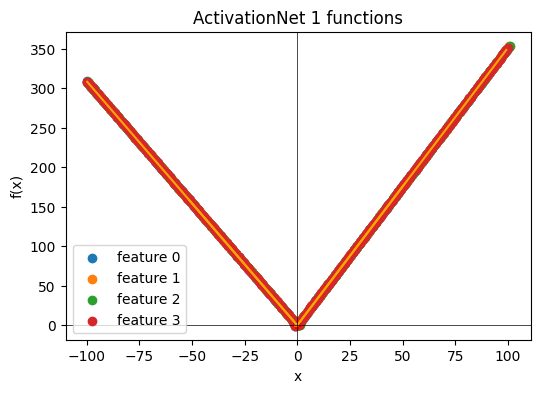

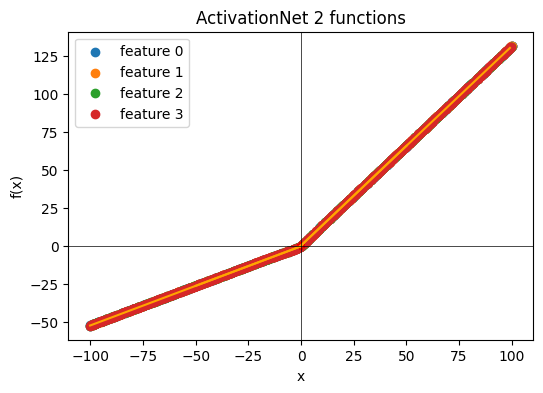

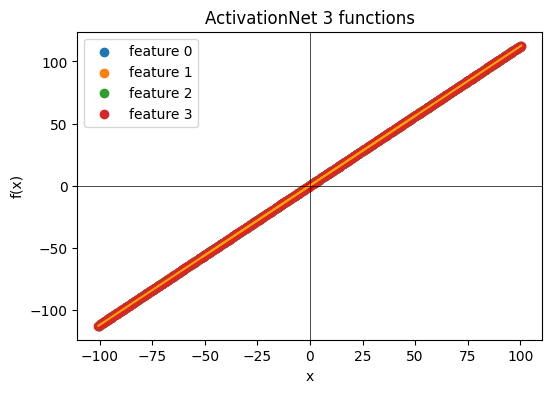

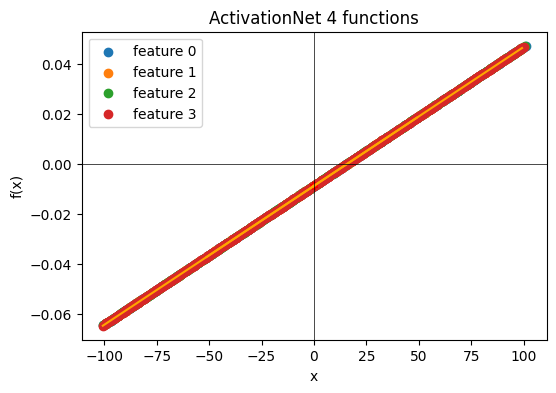

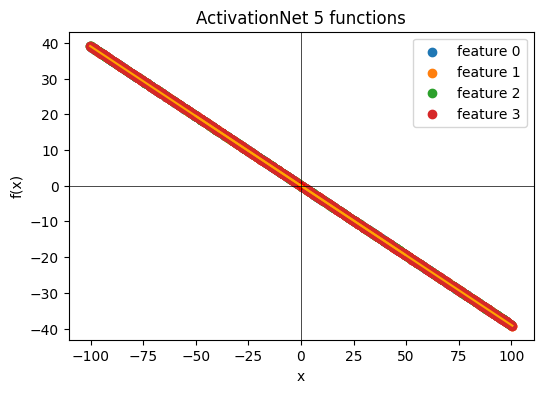

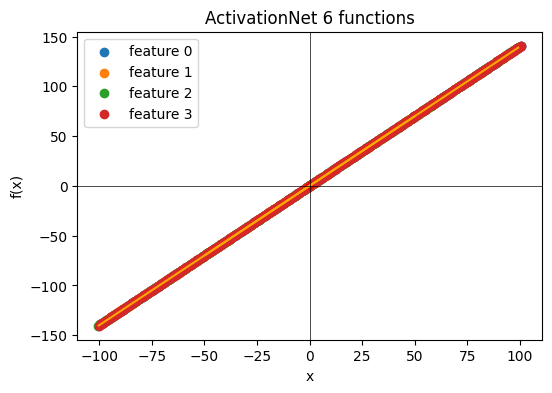

In [39]:
# (torch.rand(num_points) * 2 * x_max) - x_max for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)

def plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3]):

    
    
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]

    for i, act in enumerate(activations, 1):
        # prepare input: each feature gets the same linspace
        xs = torch.stack([
            torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)
        ], dim=1).to(device)   # [num_points, num_features]

        out, internal_out = act(xs)
        ys = out[1]
        ys = ys.detach().cpu().numpy()
        xs = xs.detach().cpu().numpy()

        int_xs, int_ys, _ = internal_out
        int_ys = int_ys.detach().cpu().numpy()[:, 0]
        int_xs = int_xs.detach().cpu().numpy()[:, 0]

        # new figure for each activation
        plt.figure(figsize=(6, 4))
        for k in select_features:
            if k < act.num_features:  # avoid index error
                plt.scatter(xs[:, k], ys[:, k], label=f"feature {k}")

        plt.scatter(int_xs, int_ys, marker="+", color="red")
        
        # Number of points to select
        select_k_points = 5
        indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
        # Prepare x and y pairs for all segments
        gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
        gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
        # Plot all segments at once
        plt.plot(gen_data_X, gen_pred_Y, color="orange")

        plt.axhline(0, color="k", linewidth=0.5)
        plt.axvline(0, color="k", linewidth=0.5)
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title(f"ActivationNet {i} functions")
        plt.show()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)
model.eval()

plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3])

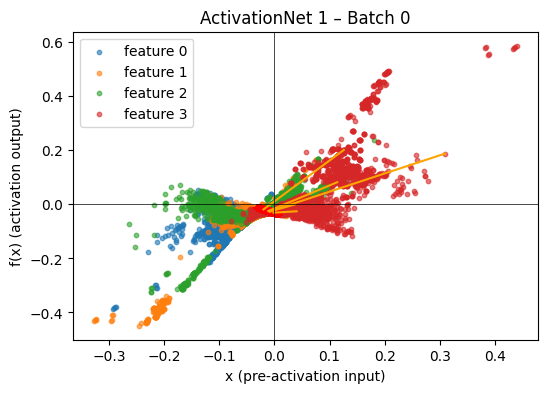

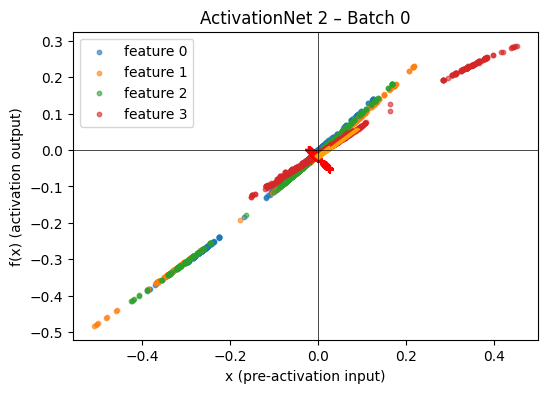

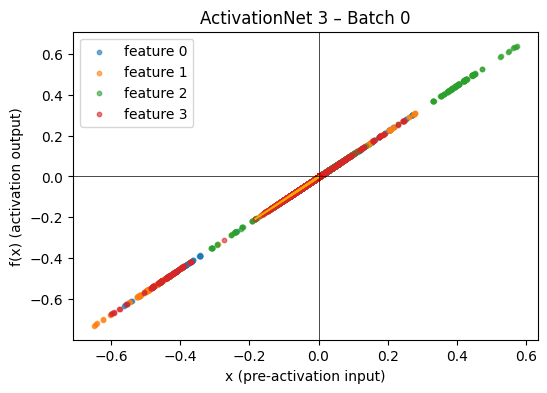

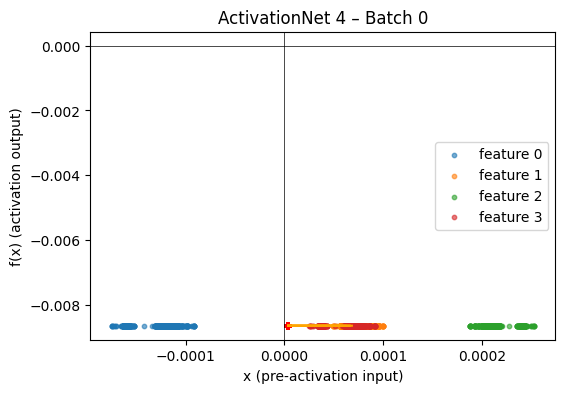

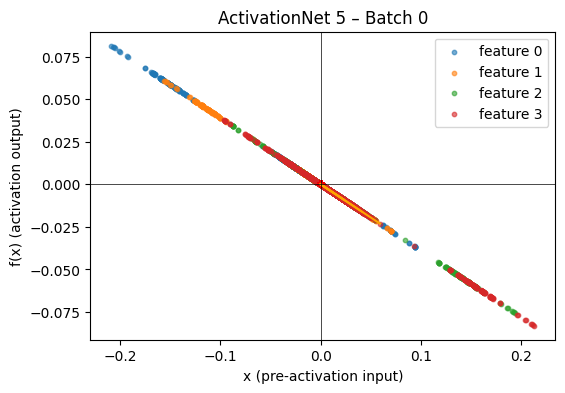

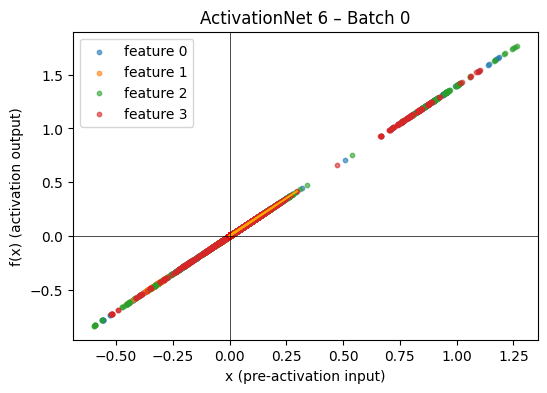

In [37]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0]):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Uses forward hooks to capture inputs and outputs of ActivationNet layers.
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = []
    for act in activations:
        hooks.append(act.register_forward_hook(hook_fn))

    # Run model on test batches
    for batch_idx, (inputs, _, _) in enumerate(test_loader):
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy()[:, 0], int_ys.numpy()[:, 0]

            plt.figure(figsize=(6, 4))
            for k in select_features:
                if k < xs.shape[1]:  # avoid index errors
                    plt.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

            plt.scatter(int_xs, int_ys, marker="+", color="red")

            # Number of points to select
            select_k_points = 5
            indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
            # Prepare x and y pairs for all segments
            gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
            gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
            # Plot all segments at once
            plt.plot(gen_data_X, gen_pred_Y, color="orange")
            
            plt.axhline(0, color="k", linewidth=0.5)
            plt.axvline(0, color="k", linewidth=0.5)
            plt.legend()
            plt.xlabel("x (pre-activation input)")
            plt.ylabel("f(x) (activation output)")
            plt.title(f"ActivationNet {i} – Batch {batch_idx}")
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()


if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3])

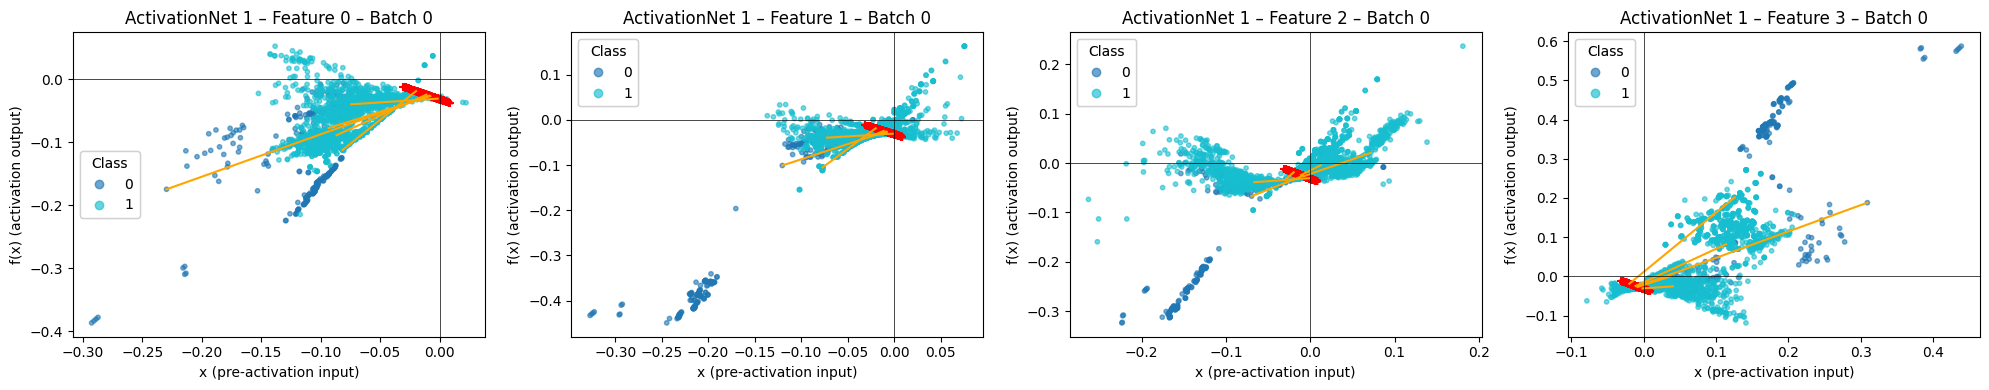

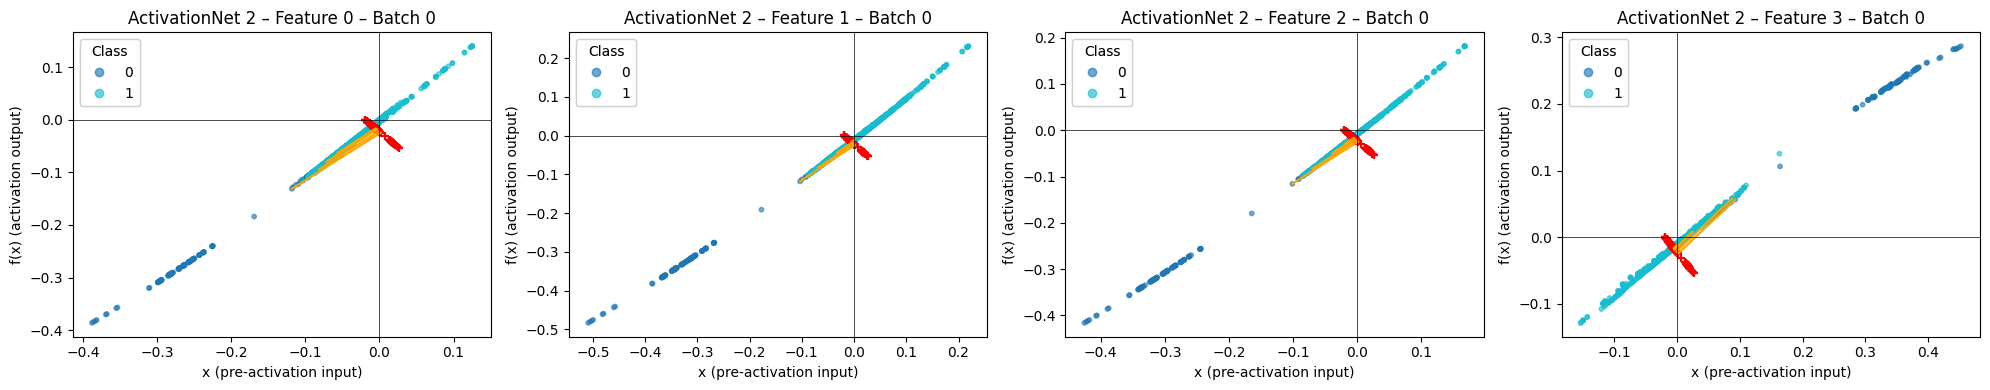

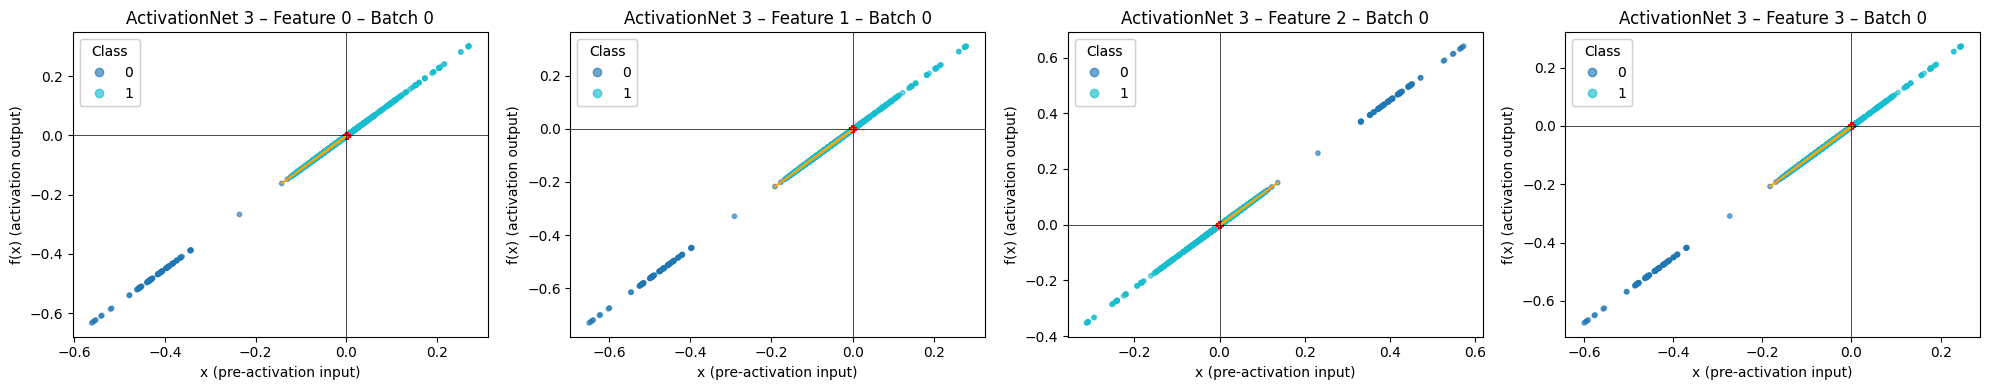

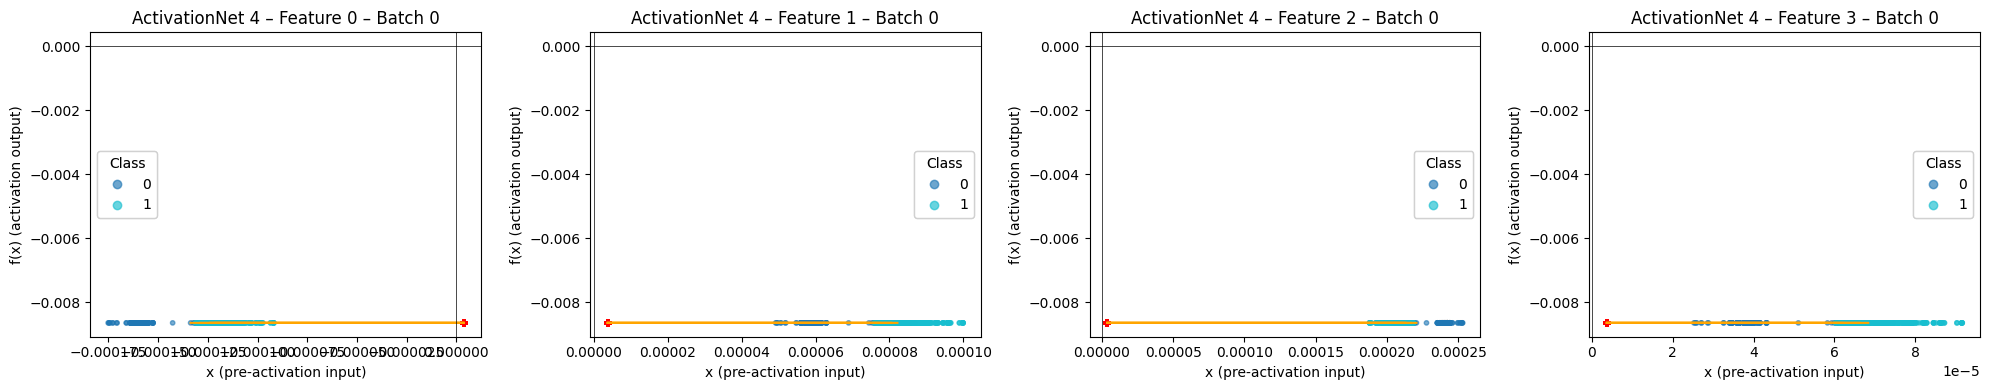

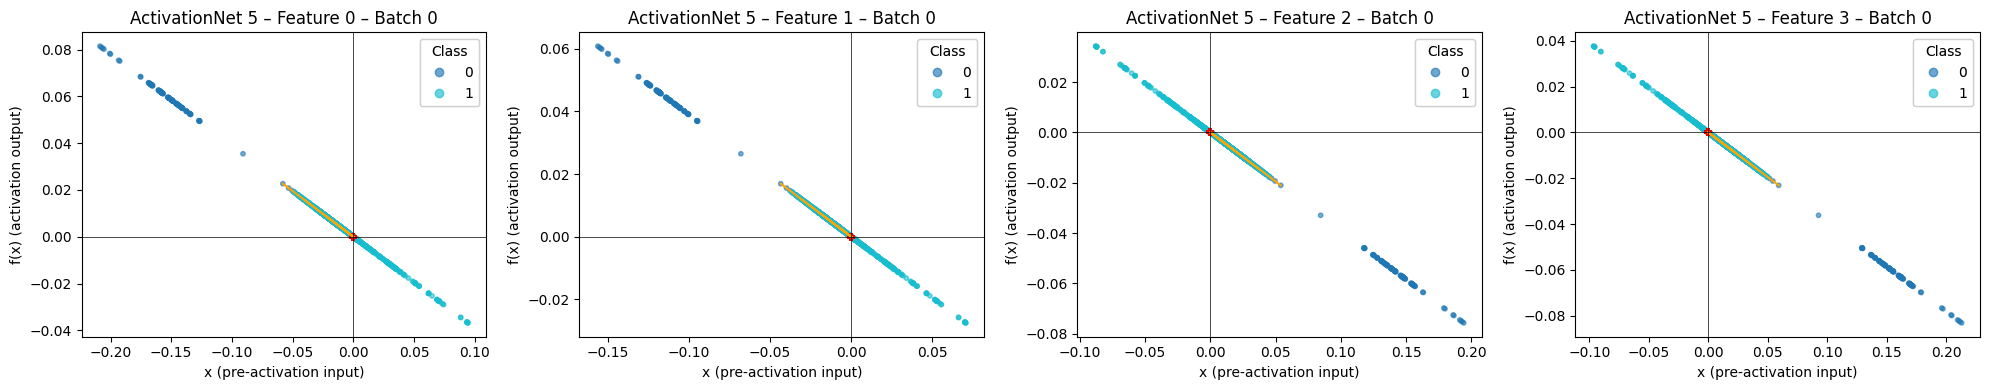

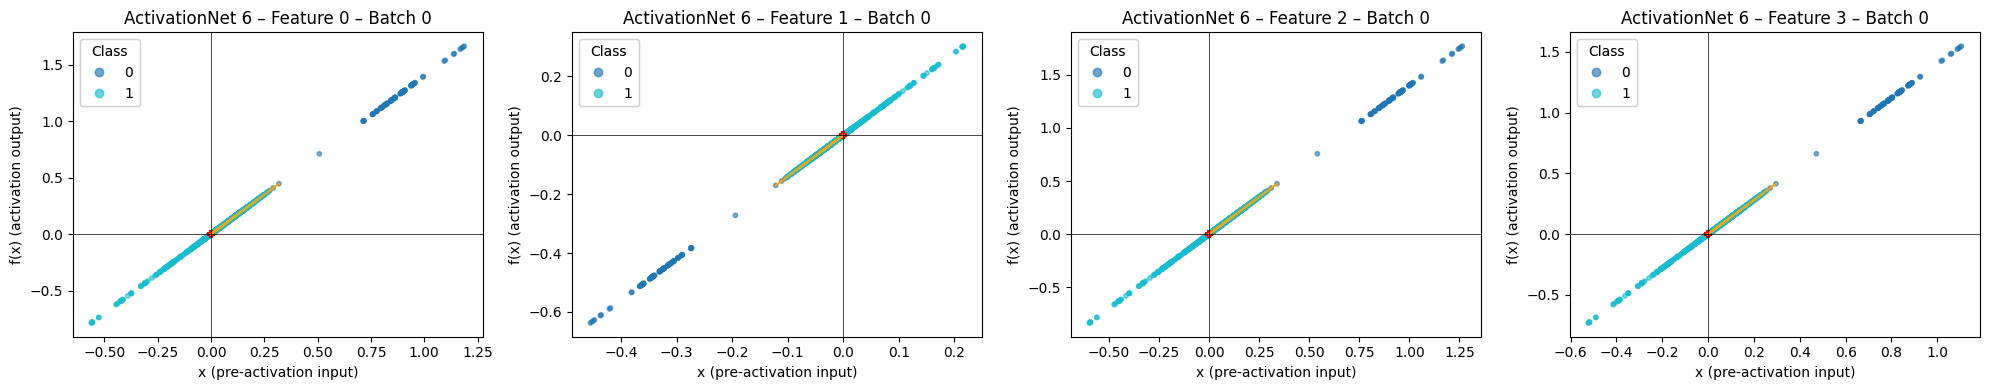

In [38]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0], color_by_class=False):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Each selected feature gets its own subplot instead of all being in one plot.

    Args:
        model: Trained KDD_Model instance
        test_loader: DataLoader with test dataset
        num_batches: Number of batches to visualize
        select_features: List of feature indices to plot
        color_by_class: If True, color points by class label from dataset
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = [act.register_forward_hook(hook_fn) for act in activations]

    # Run model on test batches
    for batch_idx, (inputs, labels, _) in enumerate(test_loader):  # assuming dataset returns (x, y, extra)
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        labels = labels.cpu().numpy() if color_by_class else None

        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy()[:, 0], int_ys.numpy()[:, 0]

            feats = [k for k in select_features if k < xs.shape[1]]
            n_feats = len(feats)
            if n_feats == 0:
                continue

            fig, axes = plt.subplots(1, n_feats, figsize=(5 * n_feats, 4), squeeze=False)

            for j, k in enumerate(feats):
                ax = axes[0, j]

                if color_by_class and labels is not None:
                    scatter = ax.scatter(xs[:, k], ys[:, k], c=labels, cmap="tab10", s=10, alpha=0.6)

                    ax.scatter(int_xs, int_ys, marker="+", color="red")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    legend1 = ax.legend(*scatter.legend_elements(), title="Class")
                    ax.add_artist(legend1)
                else:
                    ax.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

                    ax.scatter(int_xs, int_ys, marker="+", color="red")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    ax.legend()

                ax.axhline(0, color="k", linewidth=0.5)
                ax.axvline(0, color="k", linewidth=0.5)
                ax.set_xlabel("x (pre-activation input)")
                ax.set_ylabel("f(x) (activation output)")
                ax.set_title(f"ActivationNet {i} – Feature {k} – Batch {batch_idx}")

            plt.tight_layout()
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3], color_by_class=True)